In [1]:
# 주요 라이브로리 import

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys
import imblearn

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, imblearn]:
    print(i.__name__, i.__version__)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
pandas 2.2.2
numpy 2.0.2
sklearn 1.6.1
scipy 1.16.3
mlxtend 0.23.4
statsmodels 0.14.5
imblearn 0.14.0


In [2]:
# 시각화 라이브러리 Import
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
if not os.path.isfile("books.csv"):
    !git clone https://github.com/sunkusun9/DS_prob1_2510.git
    !mv DS_prob1_2510/*.csv .
    !rm -rf DS_prob1_2510
!ls -l

Cloning into 'DS_prob1_2510'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 73 (delta 40), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 1.73 MiB | 3.29 MiB/s, done.
Resolving deltas: 100% (40/40), done.
total 3668
-rw-r--r-- 1 root root   42042 Oct 31 14:33 books.csv
-rw-r--r-- 1 root root 3523745 Oct 31 14:33 ratings.csv
drwxr-xr-x 1 root root    4096 Oct 29 13:38 sample_data
-rw-r--r-- 1 root root   80658 Oct 31 14:33 to_read_ans.csv
-rw-r--r-- 1 root root   13557 Oct 31 14:33 to_read_kaggle.csv
-rw-r--r-- 1 root root   79783 Oct 31 14:33 to_read_sample.csv


강사: 멀티캠퍼스 강선구 (sunku0316.kang@multicampus.com, sun9sun9@gmail.com)

# 문제 개요

유명 도서 전자상거래 회사에서 근무하는 Junior Data Scientist 지희는

도서 전자상거래 사이트에는 사용자가 읽을 책(to read)이라고 책에 표시하는 기능이 있습니다.

사용자가 읽을 책(to read)에 남긴 내역은 그렇게 많지는 않지만,

사용자의 선호도를 직접 나타낸 것이라는 점에서 순도는 높은 데이터라고 판단됩니다.

사용자의 to read에 담길 만한 도서를 예측하여,

사용자에게 도서를 추천하는 시스템을 구상하고 있습니다.

지희가 도서 추천 프로젝트를 성공적으로 이끌기 위한 미션을 해봅니다.

## 데이터셋 구성 요약

<div style="display: flex; flex-wrap: wrap; gap: 50px;">

<!-- books.csv -->
<div style="flex: 1; min-width: 300px;">

- **books.csv**

  도서 정보

| 변수명 | 설명 | 타입 |
|:--|:--|:--|
| `book_id` | 도서 번호 | 정수형 |
| `authors` | 저자 | 문자형 |
| `original_title` | 도서 원제목 | 문자형 |
| `pub_year` | 출간연도 | 실수형 |
| `genre` | 장르 | 문자형 |
| `children` | 유아용 도서 여부 | 문자형 |

</div>

<!-- ratings.csv -->
<div style="flex: 1; min-width: 250px;">

- **ratings.csv**

  사용자 평점 데이터

| 변수명 | 설명 | 타입 |
|:--|:--|:--|
| `user_id` | 사용자 ID | 정수형 |
| `book_id` | 도서 번호 | 정수형 |
| `rating` | 평점 | 정수형 |

</div>

</div>

---

<div style="display: flex; flex-wrap: wrap; gap: 20px;">

<!-- to_read_sample.csv -->
<div style="flex: 1; min-width: 300px;">

- **to_read_sample.csv**

  사용자별 ‘읽을 책’ 목록 샘플

| 변수명 | 설명 | 타입 |
|:--|:--|:--|
| `user_id` | 고객 번호 | 정수형 |
| `to_read` | 읽을 책 리스트<br/>(\|으로 구분) | 문자열 |

</div>

<!-- to_read_kaggle.csv -->
<div style="flex: 1; min-width: 300px;">

- **to_read_kaggle.csv**

  예측 대상 사용자 목록

| 변수명 | 설명 | 타입 |
|:--|:--|:--|
| `user_id` | 고객 번호 | 정수형 |

</div>

<!-- to_read_ans.csv -->
<div style="flex: 1; min-width: 300px;">

- **to_read_ans.csv**

  정답 데이터

| 변수명 | 설명 | 타입 |
|:--|:--|:--|
| `user_id` | 사용자 ID | 정수형 |
| `to_read` | 읽을 책 리스트<br/>(\|으로 구분) | 문자열 |

</div>

</div>

#  데이터 전처리

지희는 **‘읽을 책(to read)’** 목록이 사용자의 선호도를 직접적으로 반영하지만 데이터의 양이 많지 않기 때문에,

사용자 성향을 더 잘 파악하기 위해 **도서 평점 정보**를 함께 활용하기로 했습니다.  

이에 따라 연구소에 사용자의 선호도를 추출할 방법을 문의한 결과, 다음과 같은 가이드를 받았습니다.

---

도서 평점 데이터에 내재된 사용자와 도서의 특징을 **n차원 실수 벡터**로 추출하여 벡터 간의 관계를 분석할 수 있습니다.

임베딩은 높은 복잡도를 지닌 변수, 여기서는 고차원의 범주형 변수인 user_id, book_id와 같은 변수를

나타내는 저차원의 연속형 벡터를 의미합니다.

**ratings**에서 **사용자별 임베딩(user embedding)** 과 **도서별 임베딩(book embedding)** 을 추출하는 방법을 알려 드립니다.

---

**사용자 임베딩 (User embedding)**

각 사용자에 대한 내재 벡터를 모으면,  
전체 사용자를 행으로 하는 **(사용자 수 × n)** 차원의 행렬로 표현할 수 있습니다.  

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">
    
| user_id | $u_0$ | $u_1$ | $u_2$ | ... | $u_n$ |
|:--|:--|:--|:--|:--|:--|
| 1 | 0.251 | 0.10 | 0.03 | ... | 0.15 |
| 4 | 0.080 | 0.15 | 0.01 | ... | 0.80 |
| ... | ... | ... | ... | ... | ... |
| 53394 | 0.010 | 0.81 | 0.12 | ... | 0.92 |

</div>

※ 위 수치는 예시이며 실제 값과는 무관합니다.  

💡Hint: `user_id`를 인덱스로 한 `pd.DataFrame` 구조를 권장합니다.

---

**도서 임베딩 (Book embedding)**

각 도서의 특성을 실수 벡터로 추출하면,  
전체 도서를 행으로 하는 **(도서 수 × n)** 차원의 행렬로 표현할 수 있습니다.  

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

| book_id | $b_0$ | $b_1$ | $b_2$ | ... | $b_n$ |
|:--|:--|:--|:--|:--|:--|
| 1 | 0.10 | 0.128 | 0.50 | ... | 0.10 |
| 2 | 0.07 | 0.180 | 0.25 | ... | 0.02 |
| ... | ... | ... | ... | ... | ... |
| 2355 | 0.08 | 0.110 | 0.02 | ... | 0.05 |

</div>

※ 위 수치는 예시이며 실제 값과는 무관합니다.  

💡Hint: `book_id`를 인덱스로 한 `pd.DataFrame` 구조를 권장합니다.

---

**내재 속성 추출 방법**

연구소에서는 **L2 규제(규제 계수 λ)** 가 포함된 회귀모델을 사용하여  
사용자와 도서의 내재된 속성을 추출하는 방법을 제안했습니다.  

이때, 회귀계수는 다음 **정규화된 OLS(Ordinary Least Squares)** 공식을 따릅니다:


$\hat{\beta} = (X^T X + \lambda I)^{-1} X^T y$

- $X$: 입력 디자인 행렬  
- $y$: 대상 변수 (rating 등)  
- $I$: $( n \times n )$ 단위 행렬 (주대각 원소는 1, 나머지는 0)

---

연구소의 검증 결과,  
이 데이터셋에서는 **차원 수 \( n = 10 \)**, **규제 계수 \( $\lambda = 15$ \)** 를 사용했을 때  
시각화를 통해 도서의 성질을 잘 반영하는 결과를 얻었다고 합니다.  

구체적인 수치 지표는 제시되지 않았지만,  
이 설정을 기반으로 내재 속성 추출을 진행합니다.



추출 과정은 아래의 **Step A-1 ~ A-5** 에서 자세히 설명합니다.

## Step A-1

ratings.csv를 불러옵니다. (데이터셋 명: **ratings**)

In [4]:
df_ratings = pd.read_csv('ratings.csv')
display(df_ratings.head())
df_ratings.info()

,user_id,book_id,rating
0,5115,409,5
1,41322,41,5
2,13438,596,3
3,39116,60,3
4,8014,23,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284736 entries, 0 to 284735
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  284736 non-null  int64
 1   book_id  284736 non-null  int64
 2   rating   284736 non-null  int64
dtypes: int64(3)
memory usage: 6.5 MB


## Step A-2

**user_coef**와 **book_coef**를 다음 초기화 루틴에 따라 초기화합니다.

**Step A-1**에서 불러온 **ratings**의 변수명을 df_ratings로 했을 때, 기준으로 만든 가이드 입니다.

Python:  user_coef, book_coef 초기화 루틴
```python
np.random.seed(123)
n = 10
df_user_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['user_id'].nunique(), n)) * 1 / (n ** 0.5),
    index=df_ratings['user_id'].unique(),
    columns=['u{}'.format(i) for i in range(n)]
)
df_book_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['book_id'].nunique(), n)) * 1 / (n ** 0.5),
    index=df_ratings['book_id'].unique(),
    columns=['b{}'.format(i) for i in range(n)]
)
```


In [5]:
np.random.seed(123)
n = 10
df_user_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['user_id'].nunique(), n)) * 1 / (n ** 0.5),
    index=df_ratings['user_id'].unique(),
    columns=['u{}'.format(i) for i in range(n)]
)
df_book_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['book_id'].nunique(), n)) * 1 / (n ** 0.5),
    index=df_ratings['book_id'].unique(),
    columns=['b{}'.format(i) for i in range(n)]
)

In [6]:
df_user_coef.head()

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9
5115,0.220243,0.090485,0.071737,0.174341,0.227516,0.133798,0.310145,0.216562,0.152084,0.123998
41322,0.108522,0.230546,0.138689,0.018872,0.125873,0.233375,0.057709,0.055483,0.168091,0.168179
13438,0.200615,0.268614,0.229093,0.193223,0.228457,0.102129,0.114408,0.072183,0.092881,0.199532
39116,0.029126,0.137148,0.136251,0.156117,0.134659,0.098746,0.134824,0.282514,0.298570,0.158695
8014,0.197311,0.036562,0.100334,0.131180,0.273951,0.079201,0.152749,0.311661,0.164276,0.193814


In [7]:
df_book_coef.head()

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
409,0.262438,0.097844,0.053097,0.275176,0.274501,0.071009,0.292345,0.165106,0.312427,0.273802
41,0.057463,0.213965,0.302129,0.022355,0.070824,0.292441,0.233511,0.028588,0.280410,0.067130
596,0.276948,0.051862,0.173178,0.110434,0.246806,0.297502,0.069824,0.299641,0.061945,0.024324
60,0.063258,0.256703,0.046376,0.073264,0.087374,0.089428,0.233503,0.265952,0.260564,0.045933
23,0.063401,0.004007,0.277435,0.309319,0.183181,0.051887,0.209688,0.164094,0.214495,0.213498


## Step A-3

**ratings**에 드러난 사용자의 특성을 추출하여 user_coef를 재구성하는 방법입니다.

**ratings**에서 user_id별로 **book_coef**에서 book_id의 벡터를 가져와서 입력변수를 구성하고,

rating 변수를 대상 변수로 하여 Ridge 회귀모델의 회귀 계수를 구합니다.

user_id별로 구한 계수를 $u_0$ ~ $u_9$ 순서대로 변수를 만들고 user_id를 인덱스하는

**user_coef**와 동일한 형태의 데이터프레임으로 재구성하여 **user_coef_next**를 만듭니다.

이 때 연구소의 제안대로 규제계수 lambda를 15로 설정합니다.

예를 들어, user_id가 1인 **ratings**가 아래와 같다면,

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

|book_id|rating|
|-------|------|
|1|5|
|5|4|
|3|3|
|...|...|
|21|4|

</div>

Ridge 회귀모델을 구하기 위한 디자인 행렬은

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

|$b_0$|$b_1$|$b_2$|...|$b_9$|rating|
|-----|-----|-----|---|-----|------|
|b(1,0)|b(1,1)|b(1,2)|...|b(1,9)|5|
|b(5,0)|b(5,1)|b(5,2)|...|b(5,9)|4|
|b(3,0)|b(3,1)|b(3,2)|...|b(3,9)|3|
|...|...|...|...|...|...|
|b(21,0)|b(21,1)|b(21,2)|...|b(21,9)|4|

</div>

가 됩니다. ※ b(i, j): **book_coef**에서 book_id=i의 j번째 요소입니다.


**Ridge 회귀를 위한 정규방정식**은 아래와 같습니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

$\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty$,

  $X$는 입력 디자인행렬,

  $y$는 대상변수입니다.

  $I$는 n×n의 단위행렬(주대각 원소는 1이고 나머지는 0인 행렬)

</div>




**Python 함수 가이드**
```
numpy.dot
numpy.eye
numpy.linalg.inv 활용 권장
```

💡Hint:

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">
    
$Δu^2=\sum_{i∈users}\sum_{j=0}^{9}\bigl(u(i,j)-u2(i,j)\bigr)^2$

</div>

※ u(i, j): user_coef에서 user_id=i의 j번째 요소

※ u2(i, j): user_coef_next에서 user_id=i의 j번째 요소

첫 번째 실행 때의 $Δu^2$는 52371.541 (넷째 자리에서 반올림해서 셋째 자리까지 표기) 입니다.


In [8]:
# β^=(XTX+λI)−1XTy ,

# 상수이므로 값을 만들어 놓고 재사용합니다.
lambI = np.eye(n) * 15 # numpy.eye 단위 행렬 생성 기능
# Ridge 회귀 계수 구하는 함수를 만듭니다.
def ridge(X, y):
    return np.dot(
        np.linalg.inv(np.dot(X.T, X) + lambI), # numpy.linalg.inv 역행렬 계산  (XTX+λI)−1
        np.dot(X.T, y) # XTy
    )

In [9]:
# user_id 1인 경우에 적용합니다.
pd.Series(ridge(
    df_book_coef.loc[df_ratings.loc[df_ratings['user_id'] == 1, 'book_id']],
    df_ratings.loc[df_ratings['user_id'] == 1, 'rating']
), index = df_user_coef.columns, name = 1)

,1
u0,1.102082
u1,1.085987
u2,1.111042
u3,1.105670
u4,1.004479
u5,0.918447
u6,0.955763
u7,0.975000
u8,0.975634
u9,1.033043


In [10]:
# 반복문으로 모든 사용자의 계수를 구하고, user_coef_next 데이터로 결합합니다.
df_user_coef_next = pd.DataFrame([
    pd.Series(ridge(
        df_book_coef.loc[df_ratings.loc[df_ratings['user_id'] == i, 'book_id']],
        df_ratings.loc[df_ratings['user_id'] == i, 'rating']
    ), index = df_user_coef.columns, name = i)
    for i in df_ratings['user_id'].unique()
])

In [11]:
# 1.groupby를 이용하여 user_id 별로 구분하게 하고
# 2. apply를 통해 전달받은 DataFrame 에서 결과를 만들어 데이터를 반환하면
# 3. 이를 결합한 결과를 얻을 수 있습니다.
df_user_coef_next = df_ratings.groupby('user_id')[['book_id', 'rating']].apply(
    lambda x: pd.Series(
        ridge(df_book_coef.loc[x['book_id']], x['rating']),
        index = df_user_coef.columns
    )
)
df_user_coef_next.head()

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9
user_id,,,,,,,,,,
1,1.102082,1.085987,1.111042,1.105670,1.004479,0.918447,0.955763,0.975000,0.975634,1.033043
4,1.276249,1.120128,1.293845,1.186997,1.195779,1.183349,1.242264,1.159640,1.230613,1.334106
9,0.851812,1.071020,1.100843,1.299525,0.957480,1.124742,1.030114,1.043045,1.146473,1.011855
24,0.852114,0.814326,0.931409,0.995677,0.998848,0.942323,1.040961,0.962426,0.930897,1.019645
35,1.043160,1.163733,1.174084,1.001414,1.111310,1.095792,1.212668,1.168254,1.220382,1.038751


In [12]:
((df_user_coef_next - df_user_coef) ** 2).sum().sum()

np.float64(52371.54119416874)

## Step A-4

**ratings**에 드러난 도서의 특성을 추출하여 book_coef를 재구성하는 방법입니다.

**ratings**에서 book_id별로 **user_coef_next**에서 user_id의 벡터를 가져와서 입력변수를 구성하고,

rating 변수를 대상 변수로 하여 Ridge 회귀모델의 회귀 계수를 구합니다.

book_id별로 구한 계수를 $b_0$ ~ $b_9$ 순서대로 변수를 만들고 book_id를 인덱스하는

**book_coef**와 동일한 형태의 데이터프레임으로 재구성하여 **book_coef_next**를 만듭니다.

이 때 연구소의 제안대로 규제계수 lambda를 15로 설정합니다.

예를 들어, book_id가 2인 **ratings**가 아래와 같다면,

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

|user_id|rating|
|-------|------|
|2|5|
|7|4|
|5|3|
|...|...|
|82|4|

</div>

Ridge 회귀모델을 구하기 위한 디자인 행렬은

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

|$u_0$|$u_1$|$u_2$|...|$u_9$|rating|
|-----|-----|-----|---|-----|------|
|u2(2,0)|u2(2,1)|u2(2,2)|...|u2(2,9)|5|
|u2(7,0)|u2(7,1)|u2(7,2)|...|u2(7,9)|4|
|u2(5,0)|u2(5,1)|u2(5,2)|...|u2(5,9)|3|
|...|...|...|...|...|...|
|u2(82,0)|u2(82,1)|u2(82,2)|...|u2(82,9)|4|

</div>

가 됩니다. ※ b(i, j): **book_coef**에서 book_id=i의 j번째 요소입니다.


**Ridge 회귀를 위한 정규방정식**은 아래와 같습니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

$\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty$,

  $X$는 입력 디자인행렬,

  $y$는 대상변수입니다.

  $I$는 n×n의 단위행렬(주대각 원소는 1이고 나머지는 0인 행렬)

</div>




**Python 함수 가이드**
```
numpy.dot
numpy.eye
numpy.linalg.inv 활용 권장
```

💡Hint:

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px;">

$Δb^2=\sum_{i∈books}{\sum_{j=0}^{j=9}[(b(i,j) - b2(i, j)]^2}$

</div>

※ b(i, j): book_coef에서 book_id=i의 j번째 요소입니다.

※ b2(i, j): book_coef_next에서 book_id=i의 j번째 요소입니다

첫 번째 실행 후의 $Δb^2$는 319.447 (넷째자리 반올림해서 셋째 자리 구함)입니다.


In [13]:
df_book_coef_next = df_ratings.groupby('book_id')[['user_id', 'rating']].apply(
    lambda x: pd.Series(
        ridge(df_user_coef_next.loc[x['user_id']], x['rating']),
        index = df_book_coef.columns
    )
)
df_book_coef_next.head()

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
book_id,,,,,,,,,,
1,0.192355,0.042065,0.815477,0.535627,0.374240,-0.133894,0.794803,1.193309,-0.113906,-0.175133
2,0.031188,0.268967,0.384290,0.652130,0.837212,0.137590,0.384286,0.911595,-0.487930,0.534697
3,-0.212777,-0.147220,0.061353,0.137344,0.698034,0.371874,0.293780,1.796305,0.679187,-1.195702
4,0.832240,-0.003386,0.254418,0.564671,0.393811,0.531700,0.666170,0.022059,0.041545,0.408804
5,0.159207,0.394457,0.450824,0.175405,0.790081,0.497142,0.294844,-0.072250,-0.218760,0.830335


In [14]:
((df_book_coef_next - df_book_coef) ** 2).sum().sum()

np.float64(319.44737773257685)

## Step A-5

```
user_coef = user_coef_next
book_coef = book_coef_next
```

으로 설정합니다.

**Step A-3~5**를 **모두 7번을 반복**합니다.

마지막 실행시,

$Δu^2$는 84.802, $Δb^2$는 15.578 (넷째 자리에서 반올림해서 셋째 자리까지 구함)

입니다.


최종 user_coef와 book_coef를 각각 데이터프레임 **user_coef**, **book_coef** 이라고 합니다.

In [15]:
np.random.seed(123)
n = 10
# β^=(XTX+λI)−1XTy ,
lambI = np.eye(n) * 15
def ridge(X, y):
    return np.dot(
        np.linalg.inv(np.dot(X.T, X) + lambI), # (XTX+λI)−1
        np.dot(X.T, y) # XTy
    )
# 한 번에 유의미성을 얻기 힘든 잠재적 데이터(임베딩, ... )들은 일단 임의의 수로 초기화하고
# 데이터에서 특징 추출 알고리즘으로 좀 더 데이터를 반영하는 수치로 만들어갑니다.
# 최적의 추출결과가 나올 때까지 반복합니다. (실험을 통해 도출 가능)
df_user_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['user_id'].nunique(), n)) * 1 / (n ** 0.5),
    index=df_ratings['user_id'].unique(),
    columns=['u{}'.format(i) for i in range(n)]
)
df_book_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['book_id'].nunique(), n)) * 1 / (n ** 0.5),
    index=df_ratings['book_id'].unique(),
    columns=['b{}'.format(i) for i in range(n)]
)
# 7번의 반복을 통해 얻습니다.
# 전체 데이터에 대한 수행의 단위를 epoch라고 합니다.
for epoch in range(7):
    df_user_coef_next = df_ratings.groupby('user_id')[['book_id', 'rating']].apply(
        lambda x: pd.Series(
            ridge(df_book_coef.loc[x['book_id']], x['rating']),
            index = df_user_coef.columns
        )
    )

    df_book_coef_next = df_ratings.groupby('book_id')[['user_id', 'rating']].apply(
        lambda x: pd.Series(
            ridge(df_user_coef_next.loc[x['user_id']], x['rating']),
            index = df_book_coef.columns
        )
    )
    print(
        epoch + 1, ((df_user_coef_next - df_user_coef) ** 2).sum().sum(), ((df_book_coef_next - df_book_coef) ** 2).sum().sum()
    )
    df_user_coef = df_user_coef_next
    df_book_coef = df_book_coef_next

1 52371.54119416874 319.44737773257685
2 3734.0253302929214 232.17238047754918
3 1179.4163988438115 82.0741224492702
4 449.8113390980181 43.54773778076587
5 230.16479542939976 28.417090265549554
6 134.1452206448101 20.456183148334343
7 84.80234424059927 15.577813361199206


**Step A-6**

books.csv를 불러옵니다.(데이터셋명: **books**)

In [16]:
# books에서 book_id는 유일한 값입니다. 식별자로 활용할 수 있어 인덱스로 지정합니다.
df_books = pd.read_csv('books.csv', index_col=['book_id'])
df_books.head()

,authors,original_title,pub_year,genre,children
book_id,,,,,
1,Suzanne Collins,The Hunger Games,2008.0,Adventure,no
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,Yes
3,Stephenie Meyer,Twilight,2005.0,Romance,no
4,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,no
5,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,no


**Step A-7**

**books**의 children을 소문자로 변환합니다.

children이 yes이면 1 no이면 0인 정수형 변수로 만듭니다.

In [17]:
# pd.Series.str 문자열 accessor를 사용하면 문자열 추출 작업을 쉽게 할 수 있습니다.
df_books['children'] = (df_books['children'].str.lower() == 'yes').astype('int')

# 문제 1

**book_coef**, **books**를 이용하여 **ratings**에서 추출한 **book_coef**가 얼마나 도서의 특징을 반영하는지 확인합니다.

## Step 1-1

**books**에서 book_id가 2인 책의 저자(authors)와 원제목(original_title)은

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:20px">
  J.K. Rowling / Harry Potter and the Philosopher's Stone
</div>

입니다.

**book_coef**에서 book_id가 2인 도서의 벡터와 유클리디언 거리가 가장 가까운 벡터의 도서 10개 중에서

book_id가 2인 경우를 제외하고, 저자가 J.K. Rowling인 책의 수 **A** 와,

이와 거리가 가장 가까운 책과의 거리 **B**를 구합니다.

**Python 함수 가이드**
```
from scipy.spatial.distance import cdist

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [18]:
from scipy.spatial.distance import cdist, pdist, squareform

# 1. cdist를 이용하여 book_id가 2의 df_book_coef의 벡터와 나머지 벡터들과 거리를 계산합니다.
# 2. 거리에 해당하는 book_id를 결과에 붙여 집계 내는데 활용합니다.
s_near10 = pd.Series(
    cdist(
        df_book_coef.loc[[2]], df_book_coef
    )[0], index = df_book_coef.index, name = 'dist'
).sort_values().pipe(
    lambda x: x.loc[x.index != 2] # book_id가 2가 아닌 데이터만을 취합니다.
).iloc[:10] # 10개의 결과를 가져옵니다.
s_near10.to_frame().T

book_id,23,18,24,21,27,25,422,185,106,89
dist,0.327303,0.534763,0.562056,0.686575,0.739443,0.767176,1.727561,1.852529,1.885201,1.917132


In [19]:
# book_id가 2인 경우를 제외하고, 저자가 J.K. Rowling인 책의 수 A
A = (df_books.loc[s_near10.index, 'authors'] == 'J.K. Rowling').sum()
# 이와 거리가 가장 가까운 책과의 거리 B
B = s_near10.loc[
    df_books.loc[s_near10.index, 'authors'] == 'J.K. Rowling'
].min()
A, B

(np.int64(7), 0.3273027337911709)

## Step 1-2

**books**의 book_id에 해당하는  **book_coef** 벡터상 가장 가까운 book_id를 구합니다. (자신은 제외합니다.)

이를 변수 nearest_id라고 합니다.

벡터 간의 거리는 다음 3가지를 사용해봅니다.

1. $\sqrt{\sum{(u_i-v_i)^2}}$

2. $1-\frac{u \cdot v}{{\|u\|}_2 {\|v\|}_2}$

3. $\sum{|u_i-v_i|}$

그리고 nearest_id의 저자(authors)를 nearest_authors라고 합니다.

nearest_id와 nearest_authors를 books에 추가하여 **books_near**를 만듭니다.

**books_near**에서 저자(authors)가 한 번만 등장하는 경우는 제외합니다.

nearest_authors와 authors가 같은 행의 비율(0~1 사이의 수)을 hit_rate라고 합니다.

hit_rate가 가장 높은 경우의 거리의 번호를 **C**, 이 때의 hit_rate를 **D**라고 합니다.

**Python 함수 가이드**
```
from scipy.spatial.distance import pdist, squareform

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [20]:
# 각각의 book_id 별과 df_book_coef의 거리를 계산합니다.
s_nearest_id = pd.DataFrame(
    squareform(
        pdist(df_book_coef)
    ), index = df_book_coef.index, columns = df_book_coef.index
).apply(
    lambda x: x.loc[x.index != x.name].idxmin(), axis=0
).rename('nearest_id')
s_nearest_id.head()

,nearest_id
book_id,
1,17
2,23
3,52
4,225
5,48


In [21]:
s_hitrate = {}
# 1. 유클리디언 거리 / 2.코사인 거리 / 3. 맨하탄 거리
for i in ['euclidean', 'cosine', 'cityblock']:
    s_nearest_id = pd.DataFrame(
        squareform(
            pdist(df_book_coef, metric = i)
        ), index = df_book_coef.index, columns = df_book_coef.index
    ).apply(
        lambda x: x.loc[x.index != x.name].idxmin(), axis=0
    ).rename('nearest_id')
    df_books_near = pd.concat([
        df_books,
        s_nearest_id,
        # pd.Series.map에 key:value 구조(Ex. dict, pd.Series)를 key에 해당하는 값을 value로 만들어 줍니다.
        s_nearest_id.map(df_books['authors']).rename('nearest_authors')
    ], axis = 1).pipe(
        lambda x: x.loc[x.groupby('authors').transform('size') > 1]
    )
    s_hitrate[i] = (df_books_near['authors'] == df_books_near['nearest_authors']).mean()
s_hitrate = pd.Series(s_hitrate)
s_hitrate

,0
euclidean,0.305630
cosine,0.281501
cityblock,0.294906


In [22]:
# hit_rate가 가장 높은 경우의 거리의 번호를 C, 이 때의 hit_rate를 D
df_hitrate = s_hitrate.rename('hitrate').reset_index().rename(
    columns={'index': 'name'}
).sort_values('hitrate', ascending = False)
df_hitrate

,name,hitrate
0,euclidean,0.305630
2,cityblock,0.294906
1,cosine,0.281501


In [23]:
# hit_rate가 가장 높은 경우의 거리의 번호를 C, 이 때의 hit_rate를 D
C = df_hitrate['hitrate'].idxmax() + 1
D = df_hitrate['hitrate'].max()
C, D

(np.int64(1), 0.30563002680965146)

## Step 1-3

**books**에서 authors의 빈도가 6개 이상인 authors의 리스트를 authors_6이라고 정의합니다.

**books**에서 authors가 authors_6에 포함된 데이터만을 뽑아내고,

**book_coef**와 book_id를 기준으로 inner 방법으로 결합하여 **books_tsne**를 만듭니다.

In [24]:
authors_6 = df_books['authors'].value_counts().pipe(
    lambda x: x.loc[x >=6]
).index.tolist()
# pd.Series.isin(container) : container에 포함되었는지 여부를 가져옵니다.
df_books_tsne = df_books.loc[
    df_books['authors'].isin(authors_6)
].join(df_book_coef, how = 'inner')
df_books_tsne.head()

,authors,original_title,pub_year,genre,children,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
book_id,,,,,,,,,,,,,,,
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263
7,J.R.R. Tolkien,The Hobbit or There and Back Again,1937.0,Fantasy,1,-0.040296,0.826658,0.640643,-1.520888,2.243273,1.290005,1.006776,0.968938,0.355651,0.498835
9,Dan Brown,Angels & Demons,2000.0,Thriller,0,0.568092,0.825211,1.920825,0.677580,1.013160,0.176846,-0.700616,1.816098,-1.286993,-1.355352
10,Jane Austen,Pride and Prejudice,1813.0,Romance,0,2.993978,-0.221471,0.256652,-0.533686,0.630380,0.387545,0.937201,1.464325,-0.413557,0.632750
18,J.K. Rowling,Harry Potter and the Prisoner of Azkaban,1999.0,Fantasy,1,0.716658,-0.725929,0.429370,0.936963,1.785559,0.525704,0.896112,1.551896,-1.143364,0.877247


In [25]:
df_books_tsne = df_books.groupby('authors').filter(
    lambda x: len(x) >= 6
).join(
    df_book_coef, how = 'inner'
)
df_books_tsne.head()

,authors,original_title,pub_year,genre,children,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
book_id,,,,,,,,,,,,,,,
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263
7,J.R.R. Tolkien,The Hobbit or There and Back Again,1937.0,Fantasy,1,-0.040296,0.826658,0.640643,-1.520888,2.243273,1.290005,1.006776,0.968938,0.355651,0.498835
9,Dan Brown,Angels & Demons,2000.0,Thriller,0,0.568092,0.825211,1.920825,0.677580,1.013160,0.176846,-0.700616,1.816098,-1.286993,-1.355352
10,Jane Austen,Pride and Prejudice,1813.0,Romance,0,2.993978,-0.221471,0.256652,-0.533686,0.630380,0.387545,0.937201,1.464325,-0.413557,0.632750
18,J.K. Rowling,Harry Potter and the Prisoner of Azkaban,1999.0,Fantasy,1,0.716658,-0.725929,0.429370,0.936963,1.785559,0.525704,0.896112,1.551896,-1.143364,0.877247


## Step 1-4

**books_tsne**의 입력변수  $b_0$, $b_1$, ..., $b_9$를 TSNE 모델을 사용하여 2개의 임베딩으로 줄여,

첫 번째 성분을 tsne_0, 두 번째 성분을 tsne_1 로 하여 **books_tsne**에 추가합니다.


TSNE 모델을 학습한 후의 원래의 공간과 임베딩 공간과의 결합분포(Joint Distribution)간의 Kullback-Leibler Divergence **E**를 구합니다.

Python 함수 가이드
```
from sklearn.manifold import TSNE
random_state=123, method='exact', perplexity=5
```

In [26]:
from sklearn.manifold import TSNE
# TSNE 각 데이터데이터 포인트 간의 거리에 대한 확률 분포를 최대한 유지하는 방향으로 차원 축소를 합니다.
tsne = TSNE(
    n_components = 2, # 2개의 차원으로 축소합니다.
    random_state=123, method='exact', perplexity=5
)
X_tsne = ['b{}'.format(i) for i in range(10)]
tsne.fit(df_books_tsne[X_tsne])

TSNE(method='exact', perplexity=5, random_state=123)

In [27]:
df_books_tsne = df_books_tsne.join(
    pd.DataFrame(
        tsne.embedding_, index = df_books_tsne.index
    ).rename(
        columns = lambda x: 'tsne_{}'.format(x)
    )
)
df_books_tsne.head()

,authors,original_title,pub_year,genre,children,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,tsne_0,tsne_1
book_id,,,,,,,,,,,,,,,,,
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263,54.771973,-4.741901
7,J.R.R. Tolkien,The Hobbit or There and Back Again,1937.0,Fantasy,1,-0.040296,0.826658,0.640643,-1.520888,2.243273,1.290005,1.006776,0.968938,0.355651,0.498835,21.130188,35.472961
9,Dan Brown,Angels & Demons,2000.0,Thriller,0,0.568092,0.825211,1.920825,0.677580,1.013160,0.176846,-0.700616,1.816098,-1.286993,-1.355352,-41.486279,14.819991
10,Jane Austen,Pride and Prejudice,1813.0,Romance,0,2.993978,-0.221471,0.256652,-0.533686,0.630380,0.387545,0.937201,1.464325,-0.413557,0.632750,3.568612,-35.161682
18,J.K. Rowling,Harry Potter and the Prisoner of Azkaban,1999.0,Fantasy,1,0.716658,-0.725929,0.429370,0.936963,1.785559,0.525704,0.896112,1.551896,-1.143364,0.877247,53.771576,-2.615290


In [28]:
# TSNE:  손실함수는 Kullback-Leibler Divergence 입니다. Kullback-Leibler Divergence 는 두 분포와의 차이를 나타냅니다.
# TSNE는 경사하강법을 이용하여 분포의 차이를 줄입니다.
E = tsne.kl_divergence_
E

np.float64(0.36979049001120023)

## Step 1-5, Optional

위에서 구한 TSNE 임베딩을 이용하여, book_coef와 authors와의 연관성을 확인할 수 있는 시각화를 해봅니다.

In [29]:
df_books_tsne.head()

,authors,original_title,pub_year,genre,children,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,tsne_0,tsne_1
book_id,,,,,,,,,,,,,,,,,
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263,54.771973,-4.741901
7,J.R.R. Tolkien,The Hobbit or There and Back Again,1937.0,Fantasy,1,-0.040296,0.826658,0.640643,-1.520888,2.243273,1.290005,1.006776,0.968938,0.355651,0.498835,21.130188,35.472961
9,Dan Brown,Angels & Demons,2000.0,Thriller,0,0.568092,0.825211,1.920825,0.677580,1.013160,0.176846,-0.700616,1.816098,-1.286993,-1.355352,-41.486279,14.819991
10,Jane Austen,Pride and Prejudice,1813.0,Romance,0,2.993978,-0.221471,0.256652,-0.533686,0.630380,0.387545,0.937201,1.464325,-0.413557,0.632750,3.568612,-35.161682
18,J.K. Rowling,Harry Potter and the Prisoner of Azkaban,1999.0,Fantasy,1,0.716658,-0.725929,0.429370,0.936963,1.785559,0.525704,0.896112,1.551896,-1.143364,0.877247,53.771576,-2.615290


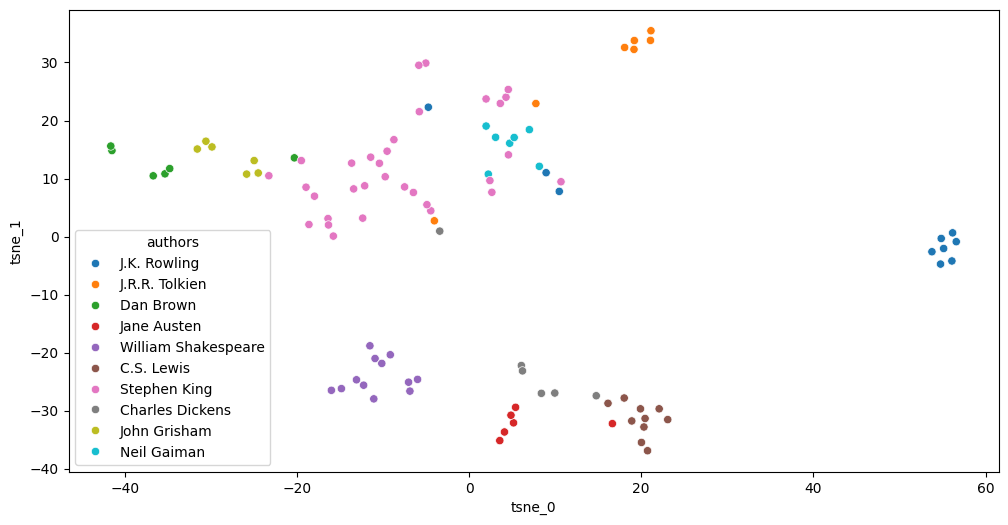

In [30]:
plt.figure(figsize=(12, 6))
# TSNE로 2차원으로 줄였을 때, authors 별로 출력 결과를 보니, authors 별로 모여있는 것을 알 수 있습니다.
sns.scatterplot(
    df_books_tsne, x = 'tsne_0', y = 'tsne_1', hue = 'authors'
)
plt.show()

## Step 1-6, Optional

**book_coef** 데이터프레임을 다음과 같은 형식으로 tab으로 분리된 출력 파일을 만듭니다.

**book_coef.tsv**
<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:20px">

|$b_0$|$b_1$|$b_2$|...|$b_9$|
|-----|-----|-----|---|----|
|b(1, 0)|b(1, 1)|b(1, 2)|...|b(1, 9)|
|b(2, 0)|b(2, 1)|b(2, 2)|...|b(2, 9)|
|...|...|...|...|...|
|b(2355, 0)|b(2355, 1)|b(2355, 2)|...|b(2355, 9)|
</div>

Python 함수 가이드
```
pd.DataFrame.to_csv
sep='\t', header=None, index=None

```

**books** 데이터프레임의 내용을 아래와 같은 내용으로 제구성하여, tab으로 분리된 출력 파일을 만듭니다.

**books.tsv**
<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:20px">

|authors|original_title|genre|pub_year|children|
|-------|--------------|-----|--------|--------|
|Suzanne Collins|The Hunger Games|2008.0|Adventure|0|
|J.K. Rowling|Harry Potter and the Philosopher's Stone|1997.0|Fantasy|1|
|...|...|...|...|...|
|George Eliot|Silas Marner: The Weaver of Raveloe|1861.0|Drama|0|
</div>

original_title에 결측치는 'Unknown'으로 바꾸어 저장합니다. (**books**의 내용은 바꾸지 않습니다.)

Python 함수 가이드
```
pd.DataFrame.to_csv
sep='\t', index=None

```


[Embedding Projector](https://projector.tensorflow.org/)에 접속합니다.

우측에 회색 바탕의 Load 버튼을 클릭하면

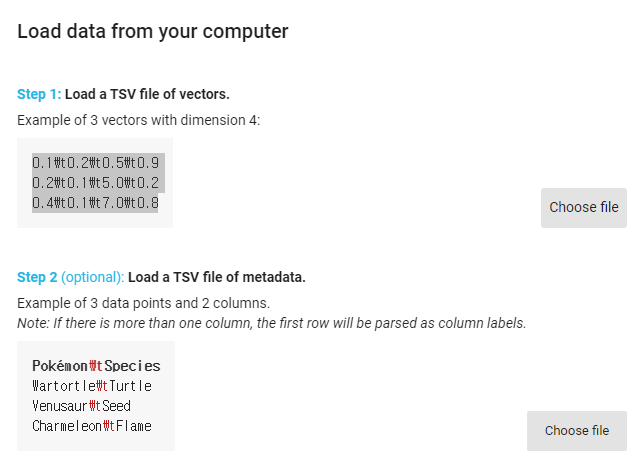

이미지가 뜨는데요,

Step1에는 book_coef.tsv

Step2에는 books.tsv

을 전달합니다.

In [31]:
df_book_coef.to_csv(
    'book_coef.tsv', sep='\t', header=None, index=None
)

In [32]:
df_books.assign(
    original_title = lambda x: x['original_title'].fillna('Unknown')
).to_csv(
    'book.tsv', sep='\t', index=None
)

# 문제 2

**book_coef**의 각 변수와 children과의 연관성과 **book_coef**의 각 변수와 genre와의 연관성을 가설 검정으로 확인합니다.

book_coef의 각 변수가 연관성은 범주형 변수로(children, genre)으로 구분했을 때,

모평균이 같다면 연관성이 없는 것이고,

모평균이 다르다면 연관성이 있는 것으로 판단합니다.

## Step 2-1

**book_coef**와 **books**를 book_id를 기준으로 inner 방법으로 결합을 하여 **book_ind**를 만듭니다.

**book_ind**의 변수 b0, b1, ..., b9를 통틀어 **B2**라고 정의합니다.

In [33]:
# join을 통해 book_id가 모두 인덱스인 df_book_coef와 df_books를 쉽게 결합할 수 있습니다.
df_book_ind = df_book_coef.join(df_books, how = 'inner')
display(df_book_ind.head())
B2 = ['b{}'.format(i) for i in range(10)]
B2

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,authors,original_title,pub_year,genre,children
book_id,,,,,,,,,,,,,,,
1,0.414964,-0.286113,0.621559,1.390130,0.738595,0.019149,1.777325,1.688889,0.263151,-0.216418,Suzanne Collins,The Hunger Games,2008.0,Adventure,0
2,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1
3,0.396106,-0.788023,0.650723,0.229239,-0.029344,1.214654,-0.453544,3.222009,1.978920,-1.930810,Stephenie Meyer,Twilight,2005.0,Romance,0
4,1.487813,0.009457,1.632723,0.478924,0.521106,0.282205,1.482096,0.145213,-0.398425,1.112995,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,0
5,1.465172,-0.690908,1.880075,0.961148,0.673412,0.998485,-0.260686,-0.283166,-0.640872,1.683384,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,0


['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9']

## Step 2-2

**book_ind**와 B2와 children 변수와의 연관성을 다음 절차에 따라 파악합니다.

B2 중에서 children과 연관성이 있는 변수의 수 A를 구합니다.

**검정 절차**

B2 각 관측값을 children으로 구분하여 변수 별로 두 개의 표본 집단을 만듭니다.

구분한 각각의 b의 표본 Kolmogorov-Smironov 검정을 사용하여 정규 분포를 따르는지 판단합니다. (**유의 수준: 1%**)

B2 변수들  중에서 children에 따른 두 모집단이 Kolmogorov-Smironov검정의 결과에 의해 모두 정규 분포를 따른다고 할 수 있다면,

t 독립 검정의 결과를 이용하여 연관성을 파악합니다. (**유의 수준 5%**)

t 독립 검정시에는 bartlett 검정을 통하여 등분산 여부(**유의 수준 5%**)를 파악하여 t 독립 검정의 방법을 정합니다.

그렇지 않다면

Mann-Whitney U 검정을 사용하여 파악합니다. (**유의 수준 5%**)


Python 함수 가이드
```
from scipy.stats import kstest, ttest_ind, manwhitneyu, norm 활용

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.

```

In [35]:
from scipy.stats import kstest, norm, zscore
# KS 테스트를 통한 정규성 검정은 norm.cdf(loc = 0, scale=1)의 기본 설정은 표준정규분포여서,
# 대상 표본을 표준화를 하거나, norm.cdf의 설정을 표본의 평균과 표본표준편차로 설정합니다.
(
    kstest(zscore(df_book_coef['b0'], ddof=1), norm.cdf),
    kstest(df_book_coef['b0'], norm.cdf, args=[df_book_coef['b0'].mean(), df_book_coef['b0'].std()])
)

(KstestResult(statistic=np.float64(0.09098710210139682), pvalue=np.float64(2.123517329576167e-05), statistic_location=np.float64(0.54795772767271), statistic_sign=np.int8(1)),
 KstestResult(statistic=np.float64(0.09098710210139671), pvalue=np.float64(2.1235173295762264e-05), statistic_location=np.float64(0.8489163597918523), statistic_sign=np.int8(1)))

In [36]:
from scipy.stats import kstest, ttest_ind, mannwhitneyu, norm
# children별로 모집단을 분리하므로 children 별로 표본을 모아, 가설 검정 함수에 전달이 쉽게 합니다.
df_children_B = df_book_ind.groupby('children')[B2].agg(list)
df_children_B

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
children,,,,,,,,,,
0,"[0.41496385101220845, 0.39610601086648334, 1.4...","[-0.28611296983429213, -0.7880225295110987, 0....","[0.6215586528544996, 0.6507233236154963, 1.632...","[1.3901303617326857, 0.22923912168024518, 0.47...","[0.7385949976224916, -0.02934404317054659, 0.5...","[0.01914856665661624, 1.214653680974525, 0.282...","[1.777324851030965, -0.45354356419738995, 1.48...","[1.6888890618427301, 3.2220088745224267, 0.145...","[0.26315061076940083, 1.9789196194933076, -0.3...","[-0.21641813173314262, -1.9308104376916866, 1...."
1,"[0.7233414002107104, -0.04029599117703242, 0.7...","[-0.5440516310099497, 0.8266575813784396, -0.7...","[0.539464892906734, 0.6406429142236583, 0.4293...","[0.5814563881911257, -1.5208877478790184, 0.93...","[1.7674512429667892, 2.243273402630796, 1.7855...","[0.4706594131378985, 1.2900049250586179, 0.525...","[0.8542647735513889, 1.006775666399239, 0.8961...","[1.738305485638674, 0.9689382434587757, 1.5518...","[-1.3793953894336184, 0.3556509723453338, -1.1...","[1.0142634277259432, 0.4988348457018219, 0.877..."


In [37]:
# 각 표본의 모집단 별로 정규성 검정을 수행합니다.
df_kstest_pvalue = df_children_B.map(
    lambda x: kstest(zscore(x, ddof=1), norm.cdf).pvalue
)
df_kstest_pvalue

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
children,,,,,,,,,,
0,0.000043,0.00056,0.000010,0.000026,0.004898,0.107797,0.000002,0.033155,0.000016,0.000001
1,0.285410,0.02128,0.598956,0.015986,0.056574,0.604261,0.470254,0.068774,0.001207,0.627960


In [38]:
# 정규 분포를 따르는지 판단합니다. (유의 수준: 1%)
s_t = (df_kstest_pvalue >= 0.01).all()
s_t.rename('T').to_frame().T

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
T,False,False,False,False,False,True,False,True,False,False


In [39]:
from scipy.stats import bartlett
# t-독립 검정의 가정인 두 모집단은 정규 분포를 따르는 변수는 t-독립 검정을 수행합니다.
# 이를 위해 t-독립 검정의 방법에는 모집단이 등분산일 경우와 이분산일 경우가 달라집니다.
# 방법을 정하기 위해 등분산 검정잉 bartlett 검점의 pvalue를 구합니다.
s_bart = df_children_B[s_t.loc[s_t].index.tolist()].apply(
    lambda x: bartlett(x[0], x[1]).pvalue, axis = 0
)
s_bart

,0
b5,2.762677e-04
b7,3.066081e-07


In [40]:
 s_ttest = df_children_B[s_t.loc[s_t].index.tolist()].apply(
    lambda x: ttest_ind(
        x[0], x[1],
        equal_var = s_bart[x.name] >= 0.05 # 등분산 여부(**유의 수준 5%**)
    ).pvalue, axis = 0
)
 s_ttest

,0
b5,3.610139e-04
b7,1.303303e-08


In [41]:
# t-독립 검정의 가정을 만족하지 않는 정규 분포를 따르지 않는 변수를 구합니다.
s_m = s_t.loc[~s_t].index
s_m

Index(['b0', 'b1', 'b2', 'b3', 'b4', 'b6', 'b8', 'b9'], dtype='object')

In [42]:
# 비모수 방법인 Mann-Whitney U 검정을 사용하여 파악합니다. (유의 수준 5%)
s_mann = df_children_B[s_t.loc[s_m].index.tolist()].apply(
    lambda x: mannwhitneyu(x[0], x[1]).pvalue, axis = 0
)
s_mann.rename('mann-whiteny U pcalue').to_frame().T

,b0,b1,b2,b3,b4,b6,b8,b9
mann-whiteny U pcalue,0.004231,0.000015,0.000581,0.002836,1.840937e-07,6.693433e-15,0.007141,3.998356e-08


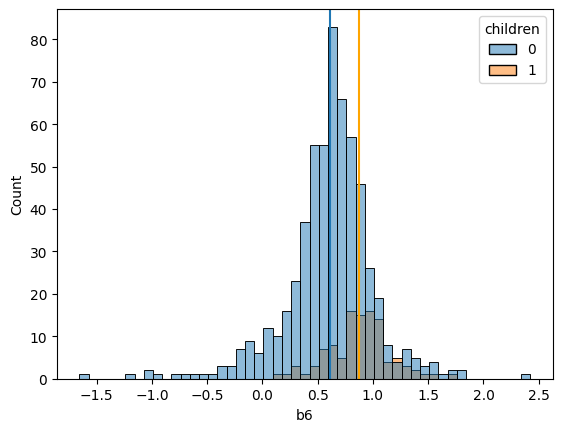

In [43]:
sns.histplot(df_book_ind, x = 'b6', hue = 'children')
plt.axvline(df_book_ind.loc[df_book_ind['children'] == 0, 'b6'].mean())
plt.axvline(df_book_ind.loc[df_book_ind['children'] == 1, 'b6'].mean(), c = 'orange')

In [45]:
# 모든 B가 children과 연관 있습니다.
(s_ttest < 0.05).sum() + (s_mann < 0.05).sum()

np.int64(10)

## Step 2-3

**book_ind**에서 genre의 출현 빈도가 40회 이상인 genre에 해당하는 행들만을 남겨 **book_ind2**를 만듭니다.

In [46]:
df_book_ind2 = df_book_ind.groupby('genre').filter(lambda x: len(x) >= 40)
df_book_ind2.head()

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,authors,original_title,pub_year,genre,children
book_id,,,,,,,,,,,,,,,
1,0.414964,-0.286113,0.621559,1.390130,0.738595,0.019149,1.777325,1.688889,0.263151,-0.216418,Suzanne Collins,The Hunger Games,2008.0,Adventure,0
2,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1
3,0.396106,-0.788023,0.650723,0.229239,-0.029344,1.214654,-0.453544,3.222009,1.978920,-1.930810,Stephenie Meyer,Twilight,2005.0,Romance,0
4,1.487813,0.009457,1.632723,0.478924,0.521106,0.282205,1.482096,0.145213,-0.398425,1.112995,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,0
5,1.465172,-0.690908,1.880075,0.961148,0.673412,0.998485,-0.260686,-0.283166,-0.640872,1.683384,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,0


In [47]:
df_book_ind2['genre'].value_counts()

,count
genre,
Mystery,113
Fantasy,97
Adventure,93
Romance,81
Biography,76
Horror,41


## Step 2-4

**book_ind2**에서 B2 변수들과 genre와의 연관성을 다음 검정 절차를 통해 확인합니다.

genre와 B2 변수와의 연관성이 있는 변수의 수 B를 구합니다.

**검정 절차**

B2의 변수가 모두 genre 별 모집단이 모두 정규분포를 따르고, 서로 분산이 같다면 일원분산분석(one-way ANOVA)를 통해

genre와의 연관성을 파악합니다.

정규성 검정은 Shapiro-Wilk 검정을 통해 파악(**유의 수준 5%**)하고, 등분산 여부는 bartlett 검정을 통해 파악(유의 수준 5%) 합니다.

그렇지 않다면, Levene 검정을 통해 연관성을 파악합니다. (**유의 수준 5%**)


Python 함수 가이드
```
from scipy.stats import shapiro, f_oneway, levene 활용

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.

```

In [48]:
# list unpacking: 리스트의 내용을 풀어서 함수에 전달합니다.
def lu(*args):
    print(len(args), args)
# *: list unpacking  연산자
lu(['A', 'B']), lu(*['A', 'B'])

1 (['A', 'B'],)
2 ('A', 'B')


(None, None)

In [49]:
# genre 별로 표본을 모아 list로 만듭니다.
df_genre_B = df_book_ind2.groupby('genre')[B2].agg(list)
df_genre_B

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
genre,,,,,,,,,,
Adventure,"[0.41496385101220845, 0.8220290253822036, 0.07...","[-0.28611296983429213, 0.4332615555635577, -0....","[0.6215586528544996, 1.7082532350917266, 0.199...","[1.3901303617326857, 0.8538484172275496, 0.949...","[0.7385949976224916, -0.25715224780143076, 0.7...","[0.01914856665661624, 0.5361656047594838, 0.47...","[1.777324851030965, 0.9632376823678754, 1.1897...","[1.6888890618427301, 1.1065297195399881, 1.950...","[0.26315061076940083, -0.9095548611884681, 0.3...","[-0.21641813173314262, 0.7572684778452654, 0.2..."
Biography,"[1.4113654673915903, 0.3775287494706294, 0.175...","[-0.13927874963020592, 0.9209293862542722, -0....","[1.6463888323966316, 1.752196401458038, 1.7430...","[0.02370113081279257, 0.4685358745402368, -0.6...","[0.7868061004404404, -0.14262270595432228, -1....","[-0.075089895354564, 0.5268838012708823, 1.563...","[0.5484767398098072, 0.02273900945768048, 0.87...","[0.5092372570562481, 1.6909411840937107, 2.067...","[0.9267133942536887, -0.7253456018120801, 1.16...","[1.0378074831850412, 0.7884987051927084, -0.54..."
Fantasy,"[0.7233414002107104, -0.04029599117703242, 0.7...","[-0.5440516310099497, 0.8266575813784396, -0.7...","[0.539464892906734, 0.6406429142236583, 0.4293...","[0.5814563881911257, -1.5208877478790184, 0.93...","[1.7674512429667892, 2.243273402630796, 1.7855...","[0.4706594131378985, 1.2900049250586179, 0.525...","[0.8542647735513889, 1.006775666399239, 0.8961...","[1.738305485638674, 0.9689382434587757, 1.5518...","[-1.3793953894336184, 0.3556509723453338, -1.1...","[1.0142634277259432, 0.4988348457018219, 0.877..."
Horror,"[1.0461403967940353, -0.4125049227163302, 0.71...","[1.3733404962284705, 0.4778410312003052, 1.091...","[0.539027018586336, 1.1379937797646384, 0.6159...","[0.5770083942201607, 1.0425604132638373, 1.239...","[1.1628229411412128, 1.3107939385166358, 0.893...","[0.580733076178924, 0.6971767253418957, 0.7831...","[-0.15056813214440812, 1.095099509287576, 0.32...","[0.3688073420139077, 0.23627973179983996, 0.26...","[0.6032949118596953, 0.6499522459878477, 0.145...","[0.30862857728148185, 0.1711723531226923, 0.47..."
Mystery,"[1.4878130504235099, 0.8227245143792423, -0.80...","[0.009456613297897931, -1.709974048442784, 1.6...","[1.6327230580052117, 2.7012056938395013, 2.095...","[0.4789241962325246, 0.5435270448688918, 0.074...","[0.5211060086438417, 0.355002772208296, 1.3059...","[0.2822049896238177, 1.5758089033647629, -0.00...","[1.4820963506034186, 0.39794949535653146, 0.05...","[0.14521315594950845, -0.6737025921969313, 1.1...","[-0.39842494650124394, 1.2781210505075506, -0....","[1.1129949805191401, 0.7736054182701793, 0.632..."
Romance,"[0.39610601086648334, 1.4651724199108322, 0.41...","[-0.7880225295110987, -0.6909084712395632, 0.3...","[0.6507233236154963, 1.880074782556031, 1.2839...","[0.22923912168024518, 0.9611483378190506, 0.79...","[-0.02934404317054659, 0.6734117181491699, 0.5...","[1.214653680974525, 0.9984854949950162, 0.3529...","[-0.45354356419738995, -0.26068608043808794, 0...","[3.2220088745224267, -0.28316624705452687, 0.7...","[1.9789196194933076, -0.6408719219769949, 0.76...","[-1.9308104376916866, 1.683384255498865, 0.472..."


In [50]:
from scipy.stats import shapiro
# 각 표본별로 정규성을 Shapiro-Wilk 검정을 파악합니다.
s_shapiro = df_genre_B.map(lambda x: shapiro(x).pvalue >= 0.05).all()
# 모든 B 변수별 표본이 정규 분포를 따르는지 확인합니다.
s_shapiro.rename('shapiro').to_frame().T

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
shapiro,False,False,False,False,False,False,False,False,False,False


In [51]:
# bartlett 검정은 정규 분포를 따른다는 가정을 하고 있습니다. 또한 일원분산 분석도 모집단이 정규분포를 따르는 가정을 하고 있습니다.
# 따라서 가정에 따르지 않아, 의미가 떨어지지만, 참고적으로 수행합니다.
s_bart = df_genre_B.apply(
    lambda x: bartlett(*x).pvalue, axis= 0
)
s_bart.rename('bart_pvalue').to_frame().T

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
bart_pvalue,1.044998e-10,0.000093,5.559681e-10,0.000139,0.000281,0.003432,1.383761e-15,0.000002,1.931008e-14,2.783815e-16


In [52]:
# 모든 변수에 대해서 비모수 검정법인 levene를 통해 중안값이 같은지의 여부로 연관성을 파악합니다.
from scipy.stats import levene
s_levene = df_genre_B.apply(
    lambda x: levene(*x).pvalue, axis= 0
)
s_levene.rename('levene_pvalue').to_frame().T

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
levene_pvalue,0.00034,0.0279,0.000189,0.04522,0.174886,0.029838,0.000013,0.02054,0.000384,0.002385


In [53]:
(s_levene < 0.05).sum()

np.int64(9)

In [54]:
# 참고로 일원분산분석(one-way ANOVA)를 수행해서 결과를 얻어 봅니다.
from scipy.stats import f_oneway
s_oneway_anova = df_genre_B.apply(
    lambda x: f_oneway(*x).pvalue, axis= 0
)
s_oneway_anova.rename('oneway_anova_pvalue').to_frame().T

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
oneway_anova_pvalue,2.006122e-11,0.039739,1.301738e-09,5.558307e-11,9.821694e-22,0.051336,0.000032,1.956638e-07,0.002822,0.001333


# 문제 3

**user_coef**가 사용자의 성향을 반영하고 있는지, **user_coef**를 입력으로 하는 예측 모델을 만들어 확인합니다.

사용자의 유형은 **ratings**에 **books**의 genre 정보를 결합하고 사용자별 genre의 평가 내역을 만들고, 이를 군집 분석하여 얻습니다.

**user_coef**의 u0, u1, ..., u9 변수만으로 사용자가 유형을 분류하는 모델을 성능을 측정합니다.

**user_coef** 통한 사용자 유형 분류 모델의 성능으로 **user_coef**가 사용자의 특성을 얼마만큼 나타낼 수 있을지를 확인합니다.


## Step 3-1

**books**에서 주요 장르에 해당하는

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">
    
Adventure, Comedy, Biography, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller, Drama

</div>

에 해당하는 행을 선택하고 book_id와 genre 열만으로 **books2**를 만듭니다.

**ratings**와  **books2**를 book_id를 기준으로 inner 방식의 결합을 하여 **ratings2**를 구성합니다.

In [55]:
genres = "Adventure, Comedy, Biography, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller, Drama"
genres = genres.split(', ')
df_books2 = df_books.loc[df_books['genre'].isin(genres), ['genre']]
df_ratings2 = df_ratings.join(df_books2, on='book_id')
df_ratings2.head()

,user_id,book_id,rating,genre
0,5115,409,5,Comedy
1,41322,41,5,Fantasy
2,13438,596,3,Thriller
3,39116,60,3,Mystery
4,8014,23,4,Fantasy


## Step 3-2

**ratings2**에서 사용자(user_id)별로 평점을 남긴 장르의 비율을 구하여 아래와 같은 데이터프레임으로 만들고,  

user_id를 기준으로 오름차순 정렬한 데이터프레임을 **user_ratings**라고 합니다.

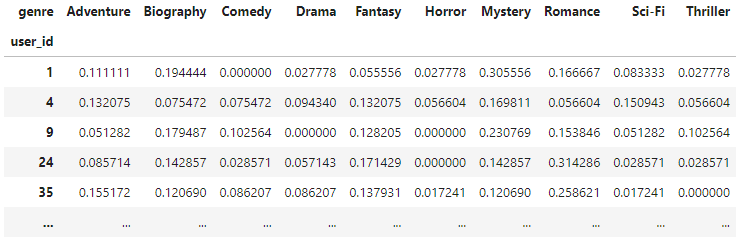

※ 위 결과는 실제 결과와는 상관이 없습니다.

In [56]:
# pd.crosstab 빈도수 테이블을 만들어 줍니다.
df_user_ratings = pd.crosstab(
    index = df_ratings2['user_id'], columns = df_ratings2['genre'],
    normalize = 'index' # normalize를 사용하여 index는 행별 비율, columns는 열별 비율을 구할 수 있습니다.
)
df_user_ratings.head()

genre,Adventure,Biography,Comedy,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
user_id,,,,,,,,,,
1,0.130435,0.195652,0.000000,0.043478,0.043478,0.021739,0.260870,0.195652,0.065217,0.043478
4,0.151515,0.075758,0.060606,0.075758,0.151515,0.060606,0.136364,0.075758,0.136364,0.075758
9,0.060000,0.180000,0.100000,0.000000,0.120000,0.020000,0.220000,0.180000,0.040000,0.080000
24,0.088889,0.111111,0.066667,0.088889,0.133333,0.000000,0.200000,0.266667,0.022222,0.022222
35,0.166667,0.111111,0.069444,0.069444,0.125000,0.013889,0.125000,0.305556,0.013889,0.000000


## Step 3-3

**user_ratings**으로 K-Means 군집화를 합니다.

군집의 수를 3에서 7까지로 바꾸어 군집화를 수행하여  실루엣 스코어(Silhouette Score)를 구합니다.

이 중에서 가장 좋은 실루엣 스코어의 군집수에 해당하는 K-Means 모델을 선택합니다.

입력 변수: Adventure, Biography, Comedy, Drama, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller

모델 평가 지표:

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">

 $s_i = \frac{(b_i - a_i)}{max(a_i, b_i)}$
  
 $a_i$: i번째 샘플이 속한 클러스터 내의 다른 샘플과의 거리간의 평균,

 $b_i$: i번째 샘플이 속하지 않은 가장 인접한 클러스터의 샘플들과의 거리의 평균
  
 $Silhouette\_Score = \frac{1}{N}\sum_{i=1}^{n}s_i$

</div>

Python 함수 가이드
```
from sklearn.cluster import KMeans
    init = 'random', n_init= 100, random_state=123 설정하여 사용합니다.

from sklearn.metrics import silhouette_score

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X_kmean = genres
# 하나의 케이스만 구해봅니다.
df_user_ratings[X_kmean]
# n_init = 100 초기점을 달리해서100번의 수행 중 가장 좋은 결과를 채택합니다.
kmeans = KMeans(n_clusters = 3, init = 'random', n_init= 100, random_state=123)
kmeans.fit(df_user_ratings[X_kmean])
silhouette_score(df_user_ratings[X_kmean], kmeans.labels_)

np.float64(0.15999280637117044)

In [58]:
s_sil = {}
# 3에서 7까지 군집수를 바꾸어 가면서 군집화 결과의 실루엣 점수를 구합니다.
for i in range(3, 8):
    kmeans = KMeans(n_clusters = i, init = 'random', n_init= 100, random_state=123)
    kmeans.fit(df_user_ratings[X_kmean])
    s_sil[i] = silhouette_score(df_user_ratings[X_kmean], kmeans.labels_)
s_sil = pd.Series(s_sil)
s_sil

,0
3,0.159993
4,0.167998
5,0.152494
6,0.134537
7,0.135081


In [59]:
# 가장 좋은 결과는 4개의 군집을 사용했을 때입니다.
s_sil.idxmax()

np.int64(4)

## Step 3-4

**Step 3-3**에서 선택한 K-Means 모델과 user_ratings를 통해 user_id의 소속 군집을 구합니다.

**user_coef**의 user_id에 대응하는 소속 군집을 파생변수명 target를 **user_coef**에 포함시켜

새로운 **user_coef2** 데이터프레임을 만듭니다.

In [60]:
# 4개의 군집으로 군집화를 합니다.
kmeans = KMeans(n_clusters = 4, init = 'random', n_init= 100, random_state=123)
kmeans.fit(df_user_ratings[X_kmean])

KMeans(init='random', n_clusters=4, n_init=100, random_state=123)

In [61]:
df_user_coef2 = df_user_coef.assign(
    target = kmeans.labels_ # 군집화 결과를 target으로 저장합니다.
)
df_user_coef2.head()

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9,target
user_id,,,,,,,,,,,
1,0.602366,0.432115,0.877043,0.570530,0.573352,0.431714,0.431534,0.474511,0.105411,0.588030,2
4,0.751706,0.119362,0.698282,0.499428,0.829948,0.394772,0.665653,0.625280,0.267532,0.719369,0
9,0.618053,0.223673,0.447749,0.619230,0.362311,1.008620,0.815284,0.732705,0.421214,0.400699,2
24,0.677476,0.459783,0.640993,0.530572,0.646476,0.500980,0.528051,0.416447,0.252221,0.588304,2
35,0.682861,0.553884,0.637354,0.209966,0.370315,0.379752,0.696045,0.546022,0.377240,0.452045,0


## Step 3-5

**user_coef2** 의 u0, u1, ..., u9 변수를 표준화하여 동일한 변수를 사용하여 **user_coef2**에 저장합니다.

**user_coef2**는 user_id 기준으로 오름차순 정렬을합니다.

**user_coef2**의 변수 u0, u1, ..., u9를 통틀어 **U2**라고 정의합니다.

Python 함수 가이드
```
from sklearn.preprocessing import StandardScaler

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [62]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
U2 = ['u{}'.format(i) for i in range(10)]
df_user_coef2[U2] = std_scaler.fit_transform(df_user_coef2[U2])
df_user_coef2[U2].head()

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9
user_id,,,,,,,,,,
1,0.002985,-0.346434,0.628087,0.121293,-0.584047,-0.514504,-1.225801,-0.830038,-1.115547,0.603042
4,0.809355,-2.183526,-0.355995,-0.306286,0.787177,-0.693796,0.318689,-0.186872,-0.107670,1.389919
9,0.087693,-1.570813,-1.735179,0.414158,-1.711830,2.285396,1.305803,0.271394,0.847737,-0.519298
24,0.408548,-0.183915,-0.671366,-0.118999,-0.193277,-0.178334,-0.589074,-1.077735,-0.202860,0.604682
35,0.437625,0.368833,-0.691399,-2.047004,-1.669059,-0.766689,0.519181,-0.524978,0.574358,-0.211672


## Step 3-6

**user_coef2**을 사용하여 4가지 모델의 성능을 측정합니다.

검증 방법은 5겹의 계층적교차검증(5-Fold Stratified Cross-Validation)을 수행하여

겹외셋(Out-of-Fold Set)의 성능의 평균을 구하여 모델의 성능을 측정합니다.

첫번째 모델(**Step 3-6-1**)의 성능은 **A**,

두번째 모델(**Step 3-6-2**)의 성능은 **B**,

세번째 모델(**Step 3-6-3**)의 성능은 **C**,

네번째 모델(**Step 3-6-4**)의 성능은 **D**로 합니다.

입력변수: **U2**

대상변수: target

성능지표

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">
$Accuracy=\frac{TP + TN}{TP + TN + FP + FN}$


**TP**: True Positive 수, **TN**: True Negative 수, **FP**: False Positive 수, **FN**: False Negative 수
</div>

Python 가이드
```
from sklearn.model_selection import StratifiedKFold을 활용합니다.
random_state=123, shuffle=True

문제에세 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold # random_state=123, shuffle=True
X_all = U2
skf = StratifiedKFold(5, random_state=123, shuffle=True) # 계층적 분리를 수행합니다.

# 공통 루틴을 만들어 이후 모델 검증에 활용하여 보다 쉽게 모델 검증을 합니다.
def eval_model(clf):
    # cross_val_score 교차검증 결과를 얻어 옵니다.
    scores = cross_val_score(
        clf, df_user_coef2[X_all], df_user_coef2['target'], scoring = 'accuracy', cv = skf
    )
    return scores.mean()

### Step 3-6-1

**1. Support Vector 분류 모델**
    
**모델 설정**

- kernel function: $K(x, x') = exp(-0.1\cdot||x-x'||^2)$
- C: 0.1
   
Python 가이드
```
from sklearn.svm import SVC
probability=True
문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [64]:
from sklearn.svm import SVC
clf_svc = SVC(
    C=0.1, # 클 수록 train에 더 맞춰진 모델이 만들어집니다.
    kernel = 'rbf',  # 두 데이터포인트의 l2-norm에 -gamma를 곱한후 지수 함수의 값을 취하는 커널은 RBF 입니다.
    gamma = 0.1
)
A = eval_model(clf_svc)
A

np.float64(0.5274549098196393)

### Step 3-6-2

**2. 로지스틱 회귀 모델**

**모델 설정**
   
- l2 규제를 사용
- C: 0.1

Python 가이드
```
from sklearn.linear_model import LogisticRegression
random_state=123, solver = 'lbfgs'
문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```



In [65]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(
    penalty = 'l2', # l2 규제를 사용
    C = 0.1, # 클 수록 train에 더 맞춰진 모델이 만들어집니다.
    random_state=123, solver = 'lbfgs'
)
B = eval_model(clf_lr)
B

np.float64(0.525250501002004)

### Step 3-6-3

**3. 신경망 분류 모델**

**모델 설정**
   
- 최적화 루틴의 최대 반복 횟수: 500회

- 은닉층 수: 2, 첫번째 은닉층 유닛수: 8개, 두번째 은닉층 유닛수: 4개
    
- 은닉층의 활성화 함수
    
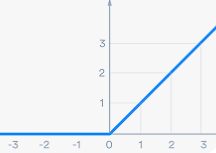
    
Python 함수 가이드
```
from sklearn.neural_network import MLPClassifier
random_state=123
문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [66]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(
    max_iter = 500, # 최적화 과정(경사 하강)의 반복 횟수
    hidden_layer_sizes=[8, 4], # 은닉층의 크기를 정합니다.
    activation = 'relu',  # 위 활성화 함수는 RELu 입니다 .
    random_state=123
)
C = eval_model(clf_mlp)
C

np.float64(0.5236472945891784)

### Step 3-6-4

**4. Voting 앙상블 분류 모델**

**모델 설정**

- 모델 구성: **Step 3-6-1**, **Step 3-6-2**, **Step 3-6-3**에서 제시한 모델
  
- 부드러운(Soft) Voting 방법 사용

Python 함수 가이드
```
from sklearn.ensemble import VotingClassifier
문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [67]:
from sklearn.ensemble import VotingClassifier

clf_vt = VotingClassifier([
    ('svm', clf_svc),
    ('lr', clf_lr),
    ('mlp', clf_mlp)
])
D = eval_model(clf_vt)
D

np.float64(0.528256513026052)

# 문제 4

Junior Data Scientist 지희는 프로젝트에서 사용자와 도서의 임베딩이 유효하다는 내용을 타부서에 공유했습니다.

이 발표에 참가한 고객관리 부서는 다음과 같은 과제를 요청했습니다.

어린이와 임산부에 대한 내용의 적합성에 따라 총 3단계로 구분하고 있습니다.

현재 기준은 장르가 Thriller나 Horror인 경우 Level 2, 어린이용이면 Level 0, 그 외에는 Level 1로 나눕니다.

장르 정보가 부정확하거나 비어 있는 경우에 Level을 구분할 수 있는 기능을 개발 부탁드립니다.

이 과제에서 Level을 분류하는 모델을 만듭니다.


## Step 4-1

**books**와 **book_coef**를 book_id 기준으로 결합하여 **genre** 셋을 만듭니다.

In [68]:
df_genre = df_books.join(df_book_coef)
df_genre.head()

,authors,original_title,pub_year,genre,children,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
book_id,,,,,,,,,,,,,,,
1,Suzanne Collins,The Hunger Games,2008.0,Adventure,0,0.414964,-0.286113,0.621559,1.390130,0.738595,0.019149,1.777325,1.688889,0.263151,-0.216418
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263
3,Stephenie Meyer,Twilight,2005.0,Romance,0,0.396106,-0.788023,0.650723,0.229239,-0.029344,1.214654,-0.453544,3.222009,1.978920,-1.930810
4,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,0,1.487813,0.009457,1.632723,0.478924,0.521106,0.282205,1.482096,0.145213,-0.398425,1.112995
5,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,0,1.465172,-0.690908,1.880075,0.961148,0.673412,0.998485,-0.260686,-0.283166,-0.640872,1.683384


## Step 4-2

**genre** 셋에서 genre가 Adventure, Comedy, Biography, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller, Drama 인 행만 뽑아,

**level_train** 셋을 만듭니다. 그 외의 행들로는 **level_test** 셋을 만듭니다.

In [69]:
genres = "Adventure, Comedy, Biography, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller, Drama"
genres = genres.split(', ')
np.array(genres)
df_level_train = df_genre.loc[df_genre['genre'].isin(genres)]
df_level_test = df_genre.loc[~df_genre['genre'].isin(genres)]
df_level_train.shape, df_level_test.shape

((627, 15), (60, 15))

## Step 4-3

**level_train**에 다음 조건에 맞게 정수형 파생변수 level을 생성합니다.

```
if genre == 'Horror' or genre == 'Thriller' then 2
else if children == 1 then 0
else if children == 0 then 1
```

In [70]:
# python 기능
# 조건의 True일 때 값 if 조건 else 아닐 때의 값
df_level_train = df_level_train.assign(
    level = df_level_train[['genre', 'children']].apply(
        lambda x: 2 if x['genre'] in ['Horror', 'Thriller'] else 0 if x['children'] == 1 else 1, axis=1
    )
)
df_level_train.head()

,authors,original_title,pub_year,genre,children,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,level
book_id,,,,,,,,,,,,,,,,
1,Suzanne Collins,The Hunger Games,2008.0,Adventure,0,0.414964,-0.286113,0.621559,1.390130,0.738595,0.019149,1.777325,1.688889,0.263151,-0.216418,1
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,0.723341,-0.544052,0.539465,0.581456,1.767451,0.470659,0.854265,1.738305,-1.379395,1.014263,0
3,Stephenie Meyer,Twilight,2005.0,Romance,0,0.396106,-0.788023,0.650723,0.229239,-0.029344,1.214654,-0.453544,3.222009,1.978920,-1.930810,1
4,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,0,1.487813,0.009457,1.632723,0.478924,0.521106,0.282205,1.482096,0.145213,-0.398425,1.112995,1
5,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,0,1.465172,-0.690908,1.880075,0.961148,0.673412,0.998485,-0.260686,-0.283166,-0.640872,1.683384,1


## Step 4-4

**level_train** 셋을 5조각으로 나누어 교차검증셋을 구성합니다.

5조각으로 나누는 방법은 level 별로 book_id순으로 0에서 시작하여 1씩 증가하는 일련번호를 만들고,

첫 번째 셋은 일련번호를 5로 나누어 나머지가 0인 행들로 구성합니다.

두 번째 셋은 일련번호를 5로 나누어 나머지가 1인 행들로 구성합니다.

...

다섯 번째 셋은 일련번호를 5로 나누어 나머지가 4인 행들로 구성합니다.


In [71]:
# level로 분리한 상태에서 일련 번호의 5로 나눈 나머지를 구하여 넣습니다.
df_level_train['no'] = df_level_train.sort_index().groupby('level')['level'].transform(
    lambda x: np.arange(0, len(x)) % 5
)
df_level_train.head().iloc[:, -5:]

,b7,b8,b9,level,no
book_id,,,,,
1,1.688889,0.263151,-0.216418,1,0
2,1.738305,-1.379395,1.014263,0,0
3,3.222009,1.978920,-1.930810,1,1
4,0.145213,-0.398425,1.112995,1,2
5,-0.283166,-0.640872,1.683384,1,3


## Step 4-5

XGBoost 모델의 하이퍼파라미터(Hyper-Parameter)를 탐색하여 성능을 최적화하고자 합니다.

하이퍼파라미터는 그리드 탐색(Grid Search)을 사용합니다.

하이퍼파라미터의 대상은 아래와 같습니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">
    
|하이퍼파라미터|탐색 대상 변수|
|--------|-----|
|트리의 최대깊이|3, 4, 5|
|트리의 수|300, 500, 800|

</div>

**성능 평가 과정**

**Step4-4**에서 구분한 5개의 셋을 첫 번째 셋부터 다섯 번째 셋까지 차례대로 검증셋(Out of foldset, 겹외셋)으로 총 5번의 검증을 다음과 같이 합니다.

1. 각각의 검증 단계에서 train셋을 먼저 book_id를 기준으로 정렬을 합니다.

2. 그 다음에 train셋은 SMOTE 알고리즘으로, 대상변수의 빈도수가 가장 높은 클래스를 제외하고 나머지 클래스를 가장 높은 빈도수가 되도록 샘플링합니다.

3. SMOTE를 통한 oversampling한 train셋으로 학습을 하고 검증셋으로 성능을 평가합니다.

- SMOTE의 샘플링 단계에서 참조하는 주변 샘플의 수 10개로 설정합니다.

4. 5개의 검증셋의 Macro Recall의 평균을 Grid Search의 선택 기준으로 합니다.


입력변수: b0, b1, ~ b9과 children, XGBoost 모델에 전달할 때 변수의 순서를 맞춰서 전달합니다.

대상변수: level

성능지표: 5개의 겹외(out-of-fold) 셋의 Macro Recall의 평균

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">

$\text{Macro Recall} = \frac{1}{N} \sum_{i=1}^{N} \text{Recall}_i$

여기서  

- $ N $: 클래스의 총 개수  
- $ \text{Recall}_i = \frac{TP_i}{TP_i + FN_i} $: 클래스 $ i $의 재현율(Recall)  
- $ TP_i $: 클래스 $ i $에 대해 True Positive 개수  
- $ FN_i $: 클래스 $ i $에 대해 False Negative 개수  


Python 함수 가이드

```
import imblearn.over_sampling
에서 제공하는 기능을 활용합니다. random_state=123으로 설정합니다.

import xgboost as xgb
에서 제공하는 기능을 활용합니다. learning_rate=0.01, random_state=123

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

최적의 파라미터의 트리의 깊이를 **A**, 트리의 수를 **B**, 그리고 성능지표  **C**를 구합니다.

In [75]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
import xgboost as xgb
# 각각의 검증 단계에서 train셋을 먼저 book_id를 기준으로 정렬을 합니다.
# 그 다음에 train셋은 SMOTE 알고리즘으로, 대상변수의 빈도수가 가장 높은 클래스를 제외하고 나머지 클래스를 가장 높은 빈도수가 되도록 샘플링합니다.
# SMOTE를 통한 oversampling한 train셋으로 학습을 하고 검증셋으로 성능을 평가합니다.
# SMOTE의 샘플링 단계에서 참조하는 주변 샘플의 수 10개로 설정합니다.
# 5개의 검증셋의 Macro Recall의 평균을 Grid Search의 선택 기준으로 합니다.
X_xgb = ['b{}'.format(i) for i in range(10)] + ['children']
def eval_smote(clf):
    smote = SMOTE(
        sampling_strategy='not majority', # 최빈 클래스가 아닌 클래스를 샘플링 -> 최빈값의 빈도에 맞게 클래스에 해당하는 데이터가 생깁니다
        k_neighbors = 10 # SMOTE 알고리즘은 샘플링 클래스의 임의의 점과 동일 클래스의 주변의 10개의 표본 / 10개의 표본중 임의로 하나 골라 직선 사이의 점을 표본으로 만듭니다.
    ) #
    scores = list()
    for i in range(5):
        df_train = df_level_train.loc[df_level_train['no'] != i]
        df_valid = df_level_train.loc[df_level_train['no'] == i]
        # smote 오브젝트로 샘플링을 합니다.
        X_re, y_re = smote.fit_resample(df_train[['b{}'.format(i) for i in range(10)] + ['children']], df_train['level'])
        clf.fit(X_re, y_re)
        # 성능을 측정합니다.
        scores.append(
            recall_score(
                df_valid['level'], clf.predict(df_valid[X_xgb]), average = 'macro'
            )# 매크로 리콜은 클래스의 불균형의 해소를 통해 성능을 높일 수 있습니다.
        )
    return np.mean(scores)
clf_xgb = xgb.XGBClassifier(learning_rate=0.01, random_state=123)
eval_smote(clf_xgb)

np.float64(0.8091168091168092)

In [76]:
params_list = []
# Grid Search의 모든 경우의 하이퍼 파라메터를 리스트로 만듭니다.
for max_depth in [3, 4, 5]:
    for n_estimators in [300, 500, 800]:
            params_list.append(
                {'max_depth': max_depth, 'n_estimators': n_estimators}
            )
cv_scores = list()
for params in params_list:
    clf_xgb = xgb.XGBClassifier(**params, learning_rate=0.01, random_state=123)
    cv_scores.append(
        eval_smote(clf_xgb)
    )
    print(params, cv_scores[-1])

{'max_depth': 3, 'n_estimators': 300} 0.828905168905169
{'max_depth': 3, 'n_estimators': 500} 0.8380463980463981
{'max_depth': 3, 'n_estimators': 800} 0.8351648351648352
{'max_depth': 4, 'n_estimators': 300} 0.834074074074074
{'max_depth': 4, 'n_estimators': 500} 0.8402523402523403
{'max_depth': 4, 'n_estimators': 800} 0.8394627594627595
{'max_depth': 5, 'n_estimators': 300} 0.8311192511192512
{'max_depth': 5, 'n_estimators': 500} 0.8274399674399675
{'max_depth': 5, 'n_estimators': 800} 0.828905168905169


In [77]:
best_params = params_list[np.argmax(cv_scores)]
best_params, np.max(cv_scores)

({'max_depth': 4, 'n_estimators': 500}, np.float64(0.8402523402523403))

In [78]:
A, B, C = best_params['max_depth'], best_params['n_estimators'], np.max(cv_scores)
A, B, C

(4, 500, np.float64(0.8402523402523403))

## Step 4-6

**level_train**을

대상변수의 빈도수가 가장 높은 클래스를 제외하고 나머지 클래스를 가장 높은 빈도수가 되도록 SMOTE 방법으로 oversampling하여

**level_smote**를 만듭니다.

이 때 SMOTE에서 참조할 주변 샘플 수는 **Step4-5**와 마찬가지로 10개로 합니다.

XGBoost 모델을 아래의 설정으로 **level_smote**을 학습합니다.

**XGBoost 모델의 설정**

- 트리의 최대깊이: **A**

- 트리의 수는 **B**

입력변수: b0, b1, ~ b9과 children, XGBoost 모델에 전달할 때 변수의 순서를 맞춰서 전달합니다.

대상변수: level


학습한 모델로 **level_test**의 level을 예측하고,

level의 예측결과가 2인 빈도수를 구하여 **D**로 합니다.

Python 함수 가이드
```
import imblearn.over_sampling
에서 제공하는 기능을 활용합니다. random_state=123으로 설정합니다.

import xgboost as xgb
에서 제공하는 기능을 활용합니다. learning_rate=0.01, random_state=123

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```


In [80]:
smote = SMOTE(
    sampling_strategy='not majority', # 최빈 클래스가 아닌 클래스를 샘플링 -> 최빈값의 빈도에 맞게 클래스에 해당하는 데이터가 생깁니다
    k_neighbors = 10 # SMOTE 알고리즘은 샘플링 클래스의 임의의 점과 동일 클래스의 주변의 10개의 표본 / 10개의 표본중 임의로 하나 골라 직선 사이의 점을 표본으로 만듭니다.
) #
X_re, y_re = smote.fit_resample(df_level_train[['b{}'.format(i) for i in range(10)] + ['children']], df_level_train['level'])
clf_xgb = xgb.XGBClassifier(**best_params, learning_rate=0.01, random_state=123)
clf_xgb.fit(X_re, y_re)
test_level = clf_xgb.predict(df_level_test[X_xgb])
test_level

array([1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [81]:
pd.Series(test_level).value_counts()

,count
1,47
2,8
0,5


In [82]:
D = pd.Series(test_level).value_counts().loc[2]
D

np.int64(8)

# 문제 5

Junior Data Scientist 지희는 사용자마다 to_read로 선정한 book_id를 예측하는 로직의 baseline을 구하고자 합니다.

to_read_sample.csv에는 to_read 데이터가 들어 있습니다.

여기에는 사용자별로 to_read 목록에 담은 도서의 book_id가 있습니다.

사용자(user_id)가 평가를 했던 도서는 to_read 목록에는 포함되어 있지 않습니다.

사용자마다 to_read로 선정할 book_id의 리스트를 만들고,

MAP@4를 사용하여 예측 로직의 성능을 평가해봅니다.

## Step5-1

to_read_sample.csv를 불러옵니다. 이 셋을  **to_read_sample** 데이터셋이라고 합니다.

**to_read_sample**의 to_reads 컬럼은 '|'으로 구분하며 복수의 book_id를 나타냅니다.

문자열로 되어 있는 to_read를 '|'으로 구분하여 정수형의 리스트로 만들어 동일 변수명으로 to_reads의 변수값으로 사용합니다.

In [83]:
df_to_read_sample = pd.read_csv('to_read_sample.csv', index_col = ['user_id'])
df_to_read_sample = df_to_read_sample.assign(
    to_reads = lambda x: x['to_reads'].str.split('|').apply(lambda y: [int(i) for i in y]) # |로 나누고, 각 나눈 문자열을 book_id와 연계를 위해 정수로 만듭니다.
)
df_to_read_sample.head()

,to_reads
user_id,
1,"[235, 112]"
24,"[61, 143, 421, 467]"
36,"[718, 65, 55, 7, 612, 741]"
60,"[736, 1214, 592, 284, 1509, 1184, 1584, 425, 8..."
75,[1005]


## Step5-2

 **to_read_sample**에 있는 사용자별(user_id)의 to_read의 예상 book_id 리스트를 아래 가이드에 맞춰 제작합니다.

1. ratings에서 book_id별 빈도수를 구하여, **rating_book_count** Series를 만듭니다.

2. **rating_book_count**에서 빈도수가 높은 book_id를 우선으로 사용자(user_id) 별로 4개의 book_id를 가지고 예상 to_read의 리스트를 만듭니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">

※ 주의: 이 때, user_id 별 to_read의 예상 book_id 리스트를 만들 때에는 **ratings**에서 user_id의 평점 내역이 있는 book_id들은 제외합니다.

</div>

위 로직으로 **to_read_sample**에 있는 user_id별로 실제로 to_read에 선택했던 book_id 리스트와

to_read 예상 book_id 리스트를 만들어 MAP@4를 구하여 **A**라고 합니다.


**성능지표**

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">
    
$MAP@4 = \frac{1}{|U|}\sum_{u∈U}\frac{1}{min(m_u,4)}\sum_{k=1}^{min(n_u,4)}Precision_{u}(k) \cdot Correct_{u}(k)$

$U$: user_id 집합

$m_u$: user_id가 $u$인 사용자의 to_read 수

$n_u$: user_id가 $u$인 사용자의 예상한 to_read의 book_id 수

$Precision_u(k)$: user_id가 $u$인 사용자의 예상한 to_reads의 k번째 까지의 Precision,

$Correct_u(k)$: user_id가 $u$인 사용자의 예상한 to_reads의 k번째 도서가 실제로 to_reads에 있다면, 1 아니면 0

Ex) user_id 가 9인 사용자가 실제로 to_read 로 선택한  book_id가 [230, 895, 112] 이고,

$m_9 = 3$,

user_id 가 9인 사용자에 대한 예측 book_id 리스트가 [1, 230, 4, 895] 라면,

$n_9 = 4$

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">
    
|k|1|2|3|4|
|-|-|-|-|-|
|$Precision_9(k)$|0/1|1/2|1/3|2/4|
|$Correct_9(k)$|0|1|0|1|

</div>
</div>

In [84]:
# user_id 별 평가 했던 book_id를 제외하는 데 활용하기 위해 user_id 별 book_id의 set을 만듭니다.
s_user_ratings = df_ratings.groupby('user_id')['book_id'].apply(set)
s_user_ratings.head()

,book_id
user_id,
1,"{256, 642, 258, 132, 4, 262, 138, 11, 268, 140..."
4,"{129, 387, 4, 5, 388, 903, 8, 264, 265, 11, 13..."
9,"{256, 1, 2, 258, 264, 9, 10, 13, 397, 16, 658,..."
24,"{4, 5, 261, 264, 136, 11, 398, 15, 1936, 401, ..."
35,"{516, 531, 540, 37, 42, 554, 557, 46, 47, 48, ..."


In [85]:
 # df_ratings에서 book_id의 빈도수를 구합니다.
 s_rating_book_count = df_ratings['book_id'].value_counts()
 s_rating_book_count.head()

,count
book_id,
4,1806
2,1766
5,1694
8,1601
28,1582


In [86]:
# user_id 1의 ratings에 없는 book_id를 빈도 목록에서의 book_id 4개를 뽑아냅니다.
s_rating_book_count.loc[
    ~s_rating_book_count.index.isin(s_user_ratings.loc[1])
].index[:4]

Index([2, 5, 8, 28], dtype='int64', name='book_id')

In [87]:
# 각각의 user_id에 대한 결과를 모아 냅니다.
s_prd = df_to_read_sample.index.to_series().apply(
    lambda x: s_rating_book_count.loc[
        ~s_rating_book_count.index.isin(s_user_ratings.loc[x])
    ].index[:4].tolist()
)
s_prd

,user_id
user_id,
1,"[2, 5, 8, 28]"
24,"[2, 8, 28, 1]"
36,"[2, 5, 8, 28]"
60,"[4, 2, 5, 8]"
75,"[4, 5, 8, 28]"
...,...
53137,"[4, 5, 28, 1]"
53268,"[4, 5, 8, 28]"
53303,"[4, 2, 5, 8]"


In [88]:
# MAPK를합니다.
# K의 제시 목록에서 실제로 to_reads에 있는 book_id를 카운트합니다.
def apk(y_true, y_pred, k = 4):
    correct = list()
    for i in y_pred[:k]:
        correct.append(
            i in y_true
        )
    pr = (np.cumsum(correct) * np.array(correct) / np.arange(1, 5)) # 각 위치의 precision을 구하기 위해 맞은 개수의 누계를 구합니다. 각 위치까지의 개수로 나누어 precision을 만듭니다.
    return pr.sum() / min(len(y_true), k) #  precision의 평균을 구합니다.
def mapk(y_true, y_pred, k = 4):
    return pd.concat([
        y_true.rename('true'),
        y_pred.rename('pred')
    ], axis=1).apply(
        lambda x: apk(x['true'], x['pred']), axis=1
    ).mean() # 모든 데이터 포인트의  apk를 구하고 평균을 만듭니다.

In [89]:
mapk(df_to_read_sample['to_reads'], s_prd)

np.float64(0.019512547465742117)

## Step5-3

전처리 과정을 분석하면,

사용자별 **user_coef**는 rating이 대상변수인 선형회귀 모델의 계수이고,

**book_coef**는 이 모델의 입력 변수라고 할 수 있습니다.

이를 아래 식으로 표현할 수 있습니다.

$rating(user\_id, book\_id) = b(book\_id, 0) \cdot u(user\_id, 0) + b(book\_id, 1) \cdot u(user\_id, 1) + ... +  b(book\_id, 9) \cdot u(user\_id, 9)$

- **b(book_id, i)**: **book_coef**에서 book_id의 i번째 계수

- **u(user_id, j)**: **user_coef**에서 user_id의 j번째 계수

이 점을 이용하여 user_coef에 존재하는 모든 user_id와 book_coef에 등장하는 모든 book_id에 대해

아래와 같이 예상 평점 **ratings_prd** 데이터프레임을 만드세요.

**ratings_prd**의 크기는 4990 x 687입니다.

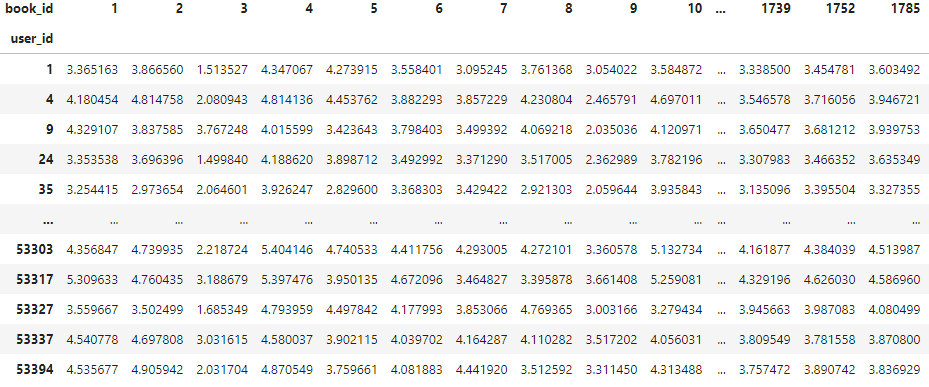

In [90]:
# 모든 user_id와 book_id 대한 예상 평점은 행렬곱으로 구합니다.
df_ratings_prd = df_user_coef.rename(columns = lambda x: x[1:]).dot(df_book_coef.rename(columns = lambda x: x[1:]).T)
df_ratings_prd.head()

book_id,1,2,3,4,5,6,7,8,9,10,...,1739,1752,1785,1936,1970,2015,2089,2124,2190,2355
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.365163,3.866560,1.513527,4.347067,4.273915,3.558401,3.095245,3.761368,3.054022,3.584872,...,3.338500,3.454781,3.603492,3.243710,3.263200,2.572949,3.202217,3.218042,3.383286,3.166451
4,4.180454,4.814758,2.080943,4.814136,4.453762,3.882293,3.857229,4.230804,2.465791,4.697011,...,3.546578,3.716056,3.946721,3.558110,3.608819,2.715110,3.396815,3.344820,3.598624,3.308279
9,4.329107,3.837585,3.767248,4.015599,3.423643,3.798403,3.499392,4.069218,2.035036,4.120971,...,3.650477,3.681212,3.939753,3.520451,3.684272,2.594804,3.504212,3.438590,3.352324,3.052793
24,3.353538,3.696396,1.499840,4.188620,3.898712,3.492992,3.371290,3.517005,2.362989,3.782196,...,3.307983,3.466352,3.635349,3.312363,3.364261,2.534376,3.299094,3.211620,3.399528,3.198215
35,3.254415,2.973654,2.064601,3.926247,2.829600,3.368303,3.429422,2.921303,2.059644,3.935843,...,3.135096,3.395504,3.327355,2.909156,3.180873,2.355774,2.997582,3.162233,3.144846,3.050818


**Step5-4**

**to_read_sample**에 있는 사용자별(user_id)는 to_read의 예상 book_id 리스트를 아래 가이드에 맞춰 제작합니다.

1. **rating_prd**에서 사용자별로 예상 rating이 높은 것을 우선으로 사용자(user_id)별로 4개의 book_id를 포함하는 예상 to_read를 만듭니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">

※ 주의: 이 때, user_id 별 to_read의 예상 book_id 리스트를 만들 때에는 **ratings**에서 user_id의 평점 내역이 있는 book_id들은 제외합니다.

</div>

위의 기준으로 **to_read_sample**에 있는 user_id별로 실제로 to_read에 선택했던 book_id 리스트와

to_read 예상 book_id 리스트를 만들어 MAP@4 **B**를 구합니다.

In [91]:
# 각 사용자별 예측 평점을으로 정렬하고, ratings에 없는 user_id의 book_id 만으로 순위를 만들어
# 4개의 bok_id를 만듭니다.
s_prd_by_rating = df_ratings_prd.loc[df_to_read_sample.index].apply(
    lambda x: x.loc[~x.index.isin(s_user_ratings.loc[x.name])].sort_values(ascending = False).iloc[:4].index.tolist(), axis = 1
)
s_prd_by_rating

,0
user_id,
1,"[5, 87, 422, 757]"
24,"[102, 490, 143, 87]"
36,"[2, 27, 422, 24]"
60,"[70, 39, 4, 45]"
75,"[24, 23, 4, 422]"
...,...
53137,"[4, 225, 143, 47]"
53268,"[24, 21, 422, 192]"
53303,"[4, 10, 87, 102]"


In [92]:
# 순위를 구합니다.
# 빈도 기반에 비해서 성능이 떨어집니다.
# Machine Learning 솔루션은 성숙한 단계가 아니면,
# 간단한 솔루션보다 안 좋을 경우가 대부분 입니다.
# 간단한 솔루션에서 고도화하는 방향이 ML 프로젝트에서 중요합니다.
mapk(df_to_read_sample['to_reads'], s_prd_by_rating) # ratings의 book_id의 빈도기반 0.019512547465742117

np.float64(0.01356901106158164)

# 문제 6

이 업무를 맡은 지희는 사용자의 평점(rating)은 낮아도 사용자들이 읽은 책이라, 관심을 보인 것이라고 생각을 했습니다.

즉 아무리 평점이 낮아도, 읽지 않은 책보다는 사용자의 관심이 있는 것이라는 겁니다.

도서의 평균 평점이 높은 책 중의 상당수는 평가수가 적은 책이 상당수를 이루고 있다는 점에서,

이러한 평점에는 치우침 현상이 있어, 평점만으로 선호도를 예측하기에는 부족하다는 생각을 했습니다.

to_read를 예측하기 위한 다른 모델을 Senior Data Scientist 재윤과 논의 끝에, 다음 모델을 생각했습니다.
```

평가를 한 책은 책을 읽음, 평가를 하지 않은 책은 책을 읽지 않음으로 하여

책을 읽었는지 여부(읽음 / 읽지 않음)로 문제를 재정의해보자는 것이다.

```

이렇게 하면, 평점을 남기지 않은 경우도 데이터로 활용할 수 있어, 평점만으로는 드러나지 않는 특성을 반영할 수 있다는 것입니다.

이를 위해, 전처리 단계의 모델을 응용하여 다음과 같은 모델을 설계했습니다.

전처리 단계에서 특성을 추출한 방법을 다음과 같이 응용합니다.


1. 아래와 같이 각각의 사용자와 도서를 벡터로 나타내어 행렬로 나타냅니다.

사용자별로 실수 벡터를 모아 (사용자수×n) 행렬로 나타냅니다. 각각의 벡터는 user_id를 통해 접근합니다. (**user_coef2**)

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

|user_id|$u_0$|$u_1$|$u_1$|...|$u_n$|
|-------|--|--|--|---|--|
|1|0.251|0.1|0.03|...|0.15|
|4|0.08|0.15|0.01|...|0.8|
|...|...|...|...|...|...|
|53394|0.01|0.81|0.12|...|0.92|

</div>

※ 위 수치는 실제 수치와는 관계 없습니다.

💡Hint: user_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.


도서별로 실수 벡터를 모아 (도서의 수×n) 행렬로 나타냅니다. 각각의 벡터는 book_id를 통해 접근합니다. (**book_coef2**)

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

|book_id|$b_0$|$b_1$|$b_1$|...|$b_n$|
|-------|--|--|--|---|--|
|1|0.1|0.128|0.5|...|0.1|
|2|0.07|0.18|0.25|...|0.02|
|...|...|...|...|...|...|
|2355|0.08|0.11|0.02|...|0.05|

</div>

※ 위 수치는 실제 수치와는 관계 없습니다.

💡Hint: book_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.

아래처럼 사용자 user_id가 도서 book_id를 읽을 Logit을 아래와 같이 정의합니다.

$Logit(user\_id, book\_id) = b(book\_id, 0) \cdot u(user\_id, 0) + b(book\_id, 1) \cdot u(user\_id, 1) + ... +  b(book\_id, n) \cdot u(user\_id, n)$

- b(book_id, i): **book_coef2**에서 book_id의 i번째 계수

- u(user_id, j): **user_coef2**에서 user_id의 j번째 계수

$\sigma(x)=\frac{1}{1 + e^{-x}}$

$\hat{y}(user\_id, book\_id) = \sigma(Logit(user\_id, book\_id))$


위와 같이 절편항을 제외한 로지스틱 회귀모델의 형태를 응용한 모델을 구상하여 **book_coef2**, **user_coef2**를 구합니다.

## Step6-1

**ratings**를 기반으로, 인덱스(행)는 user_id, 컬럼(열)은 book_id이고,

값은  **ratings**에 user_id가 book_id에 평점을 남겼으면 1, 그렇지 않으면 0인

**read** 데이터프레임으로 재구성합니다.

행은 user_id에 대해서 오름차순으로, 열은 book_id에 대해서 오름차순으로 정렬합니다.

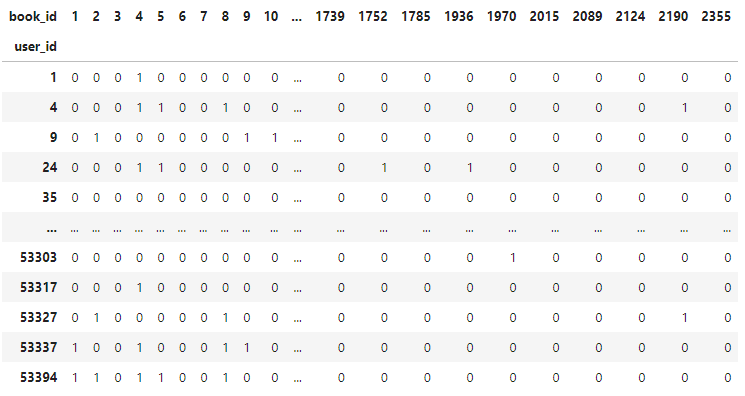


Python 함수가이드
```
pd.crosstab
```

In [93]:
# crosstab 을 이용하여 행은 user_id 열은 book_id의 빈도를 구해 평점을 남겼으면 1 아니면 0인
# 데이터프레임을 만듭니다.
df_read = (pd.crosstab(
    index = df_ratings['user_id'], columns = df_ratings['book_id']
) > 0).astype('int')
df_read.head()

book_id,1,2,3,4,5,6,7,8,9,10,...,1739,1752,1785,1936,1970,2015,2089,2124,2190,2355
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
9,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,1,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Step 6-2

n = 64로 설정을 합니다.

**book_coef2**와 **user_coef2**를 아래 루틴으로 초기화 합니다.

**Step 6-1**에서 불러온 **read**의 변수명을 df_read로 했을 때, 기준으로 만든 루틴입니다.

Python: book_coef2, user_coef2 초기화 루틴
```python
np.random.seed(123)
n = 64
df_user_coef2 = pd.DataFrame(
    np.random.random(size=(df_read.shape[0], n)) * 1 / (n ** 0.5), index=df_read.index
)
df_book_coef2 = pd.DataFrame(
    np.random.random(size=(df_read.shape[1], n)) * 1 / (n ** 0.5), index=df_read.columns
)
```

In [94]:
# 전처리의 임베딩 추출 방법과 같이 난수로 초기화합니다.
# 이후 과정에서는 업데이트를 통해 데이터에서 속성을 추출합니다.
np.random.seed(123)
n = 64
df_user_coef2 = pd.DataFrame(
    np.random.random(size=(df_read.shape[0], n)) * 1 / (n ** 0.5), index=df_read.index
)
df_book_coef2 = pd.DataFrame(
    np.random.random(size=(df_read.shape[1], n)) * 1 / (n ** 0.5), index=df_read.columns
)

## Step 6-3

행은 사용자(user_id), 열은 도서(book_id)이고 요소는 $Logit(user\_id, book\_id)$ 행렬 L 이라고 합니다.

행렬 L을 **read**와 동일한 형태로 아래에서 제시한 방법으로 구합니다.

**read**의 행에 해당하는 user_id 벡터를 user_coef2에서 가져와서 user_id의 순서에 맞게 행렬 $U$를 구성합니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

$U: N_u × n$ 행렬

</div>

**read**의 열에 해당하는 book_id 벡터를 book_coef2에서 가져와서 book_id의 순서에 맞게 행렬 $B$를 구성합니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

$B: N_b × n$ 행렬

</div>

이렇게 구성한다면 문제 6 서두에서 제시한 모델은 다음과 같이 U와 B의 행렬의 곱으로 나타낼 수 있습니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

$L = U×B^T$

- $B^T$ 는 B의 전치행렬
- $L$: $N_u × N_b$ 행렬
- $N_u$: 사용자수
- $N_b$: 도서수

</div>

행은 사용자(user_id), 열은 도서(book_id)이고 요소는 $\hat{y}(user\_id, book\_id)$ 행렬 $\hat{Y}$ 이라고 한다면,

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

$\hat{Y} = \sigma(L)$ , $\sigma(x)=\frac{1}{1 + e^{-x}}$ 가 됩니다.

</div>

손실을 아래와 같이 정의합니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">
    
$Loss(Y, \hat{Y}) = \frac{1}{N_u×N_b}\sum{\left( -y\cdot log(\hat{y}) - (1-y)\cdot log(1-\hat{y}) \right)} $

</div>

Y 는 **read** 일 때,

💡Hint: 초기 **user_coef2**, **book_coef2**으로 $Loss(Y, \hat{Y})$ 를 구하면 0.805 입니다.(소수점 4째 자리에서 반올림하여 3째 자리까지 표시)

**Python 함수 가이드**

```
from np import dot
from scipy.special import expit, xlogy
```


In [95]:
# 위의 과정은 행은 행렬곱을 통해 user_id, 열은 book_id이고 값은 user_id가 book_id에 rating을 남길 확률인 데이터프레임을
# 두 임베딩의 행렬곱을 통해 로짓을 만들고 로지스틱함수로 확률을 만듭니다.
from scipy.special import expit, xlogy
df_prob = expit(
    df_user_coef2.dot(
        df_book_coef2.T
    )
)
df_prob

book_id,1,2,3,4,5,6,7,8,9,10,...,1739,1752,1785,1936,1970,2015,2089,2124,2190,2355
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.568042,0.561616,0.565543,0.571347,0.564296,0.550504,0.561336,0.571473,0.560499,0.565230,...,0.563533,0.560381,0.562105,0.566401,0.566815,0.566856,0.558059,0.562320,0.565282,0.552586
4,0.563885,0.562983,0.564211,0.566748,0.560470,0.554132,0.557346,0.565101,0.561551,0.565524,...,0.563175,0.558400,0.556593,0.563790,0.567381,0.566279,0.550322,0.558066,0.557778,0.550946
9,0.565744,0.561649,0.565471,0.565788,0.565931,0.550982,0.561945,0.568354,0.567956,0.569664,...,0.569531,0.562088,0.562032,0.568200,0.564634,0.566196,0.558406,0.562856,0.562189,0.554259
24,0.564046,0.558875,0.562223,0.562026,0.562418,0.551885,0.559467,0.562798,0.562183,0.568726,...,0.561246,0.555464,0.554052,0.564065,0.562784,0.568355,0.553199,0.556976,0.553855,0.545337
35,0.558106,0.557216,0.557466,0.559846,0.561175,0.551370,0.556717,0.566454,0.555794,0.563498,...,0.562331,0.559988,0.557513,0.564355,0.560863,0.560478,0.550727,0.558556,0.560658,0.552604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,0.546798,0.548227,0.550651,0.553180,0.550831,0.543683,0.550257,0.550908,0.554442,0.552914,...,0.548544,0.551044,0.551456,0.552007,0.554251,0.553267,0.544795,0.550183,0.551281,0.539875
53317,0.569947,0.564211,0.570532,0.570099,0.567846,0.557649,0.565350,0.573431,0.561668,0.571019,...,0.566474,0.565691,0.566049,0.566471,0.567042,0.569592,0.558003,0.566010,0.567415,0.554358
53327,0.555214,0.554690,0.558643,0.560895,0.561455,0.553992,0.559261,0.565340,0.556297,0.560542,...,0.556274,0.553701,0.552792,0.562147,0.554499,0.557494,0.551688,0.551075,0.555070,0.546831


## Step 6-4

지희는 U와 B를 구하는 방법을 찾기 위해 여러 시간 고민 끝에,

신경망 학습의 역전파(Back-Propagation) 알고리즘을 생각해 냅니다.

아래 과정을 거쳐 $ \frac{dLoss(Y, \hat{Y})}{dU} $, $ \frac{dLoss(Y, \hat{Y})}{dB} $를 유도합니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

$\frac{dLoss(Y, \hat{Y})}{d\hat{Y}} = \frac{\hat{Y} - Y}{\hat{Y}(1 - \hat{Y})}$,

$\frac{d\hat{Y}}{dL} = \hat{Y}(1-\hat{Y})$,

$\frac{dLoss(Y, \hat{Y})}{dL} = \hat{Y} - Y$

$\frac{dLoss(Y, \hat{Y})}{dU} = \frac{dLoss(Y, \hat{Y})}{dL} × \frac{dL}{dU} = (\hat{Y} - Y)×B$

$\frac{dLoss(Y, \hat{Y})}{dB} = (\hat{Y} - Y)^T×U$

</div>

이를 이용하여 아래와 같은 경사하강법을 이용하여,

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

$ΔU = \frac{dLoss(Y, \hat{Y})}{dU}$

$ΔB = \frac{dLoss(Y, \hat{Y})}{dB}$

$U ← U - \lambda × ΔU$

$B ← B - \lambda × ΔB$

</div>

U와 B 구합니다.

$\lambda = 0.001$로 설정하여 U와 B의 업데이트를 1000회 반복합니다.


💡Hint

첫 번째 U, B 업데이트 후 $Loss(Y, \hat{Y})$ 는 0.599 (넷째자리에서 반올림하여, 셋째자리까지 표시) 입니다.

1000회 반복 후 $Loss(Y, \hat{Y})$ 은 0.111 (넷째자리에서 반올림하여, 셋째자리까지 표시) 입니다.

Python 함수 가이드
```
from np import dot

from scipy.special import expit, xlogy
```

In [96]:
lbd = 0.001
losses = list()
for epoch in range(1000):
    df_prob = expit(
        np.dot(df_user_coef2, df_book_coef2.T)
    )
    df_diff = (df_prob - df_read)
    # 손실에 대한 사용자 임베딩의 경사도를 backpropagation 알고리즘에서 사용하는 체인룰을 이용해 구했습니다.
    # 이는 결국의 평점여부 데이터프레임과 확률 데이터프레임과 차와 book_id 임베딩의 행렬곱이됩니다.
    df_user_coef_nabla = np.dot(df_diff, df_book_coef2)
    # 이는 결국의 평점여부 데이터프레임과 확률 데이터프레임과 차와 userid 임베딩의 행렬곱이됩니다.
    df_book_coef_nabla = np.dot(df_diff.T, df_user_coef2)
    # 손실이 줄어드는지 모니터링을 위해 구합니다.
    loss =  -(xlogy(df_read,df_prob) + xlogy(1 - df_read, 1 - df_prob)).sum().sum() / (len(df_user_coef2) * len(df_book_coef2))
    df_user_coef2 -= lbd * df_user_coef_nabla
    df_book_coef2 -= lbd * df_book_coef_nabla
    losses.append(loss)
    if (epoch + 1) % 50 == 0:
        df_logit_prd = df_user_coef2.dot(df_book_coef2.T)
        # 단계별 map@4를 구하여 성능을 모니터링합니다.
        s_prd_by_logit = df_logit_prd.loc[df_to_read_sample.index].apply(
            lambda x: x.loc[~x.index.isin(s_user_ratings.loc[x.name])].sort_values(ascending = False).iloc[:4].index.tolist(), axis = 1
        )
        print(epoch + 1, loss, mapk(df_to_read_sample['to_reads'], s_prd_by_logit))
print(epoch + 1, loss)

50 0.25844178067600176 0.01742474272191954
100 0.221962281014475 0.012158796984205602
150 0.17949200510004154 0.013214737768972537
200 0.15397396465083388 0.01634816465797149
250 0.14230805061070034 0.017421303175389355
300 0.13582936128901976 0.018628584007484454
350 0.13153122906857703 0.018239915249573496
400 0.12834805923234865 0.018769605415222056
450 0.1258126868729382 0.0195641406636949
500 0.12369200352927491 0.019216746464146166
550 0.12185806836368039 0.019784271641626768
600 0.12023511611014139 0.01943343789554785
650 0.11877518689717369 0.018859033625006877
700 0.1174458004894636 0.018996615486214296
750 0.11622382134592237 0.01944031698860822
800 0.11509202647131186 0.019347449232293215
850 0.1140370595171878 0.019337130592702655
900 0.11304840109715793 0.01934400968576303
950 0.11211777417946689 0.01960541522205712
1000 0.11123865002616637 0.019175471905783937
1000 0.11123865002616637


## Step 6-5

**to_read_sample**에 있는 사용자(user_id)별 to_read의 예상 book_id 리스트를 아래 가이드에 맞춰 제작합니다.

1. **to_read_sample**에 있는 각각의 user_id와 **book_coef2**의 book_id에 대해 **user_coef2**와 **book_coef2**로 각각의 user_id에 대한 book_id의 Logit을 구해 **logit**셋을 만듭니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:0px">

$Logit(user\_id, book\_id) = b(book\_id, 0) \cdot u(user\_id, 0) + b(book\_id, 1) \cdot u(user\_id, 1) + ... +  b(book\_id, n) \cdot u(user\_id, n)$

- b(book_id, i): **book_coef2**에서 book_id의 i번째 계수

- u(user_id, j): **user_coef2**에서 user_id의 j번째 계수

</div>

2. **logit**은 사용자(user_id) 별로 book_id에 대한 읽을 가능성을 나타냅니다. 이를 통해 사용자(user_id)별로 가능성이 높은 4개의 book_id를 포함하는 예상 to_read를 만듭니다.

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">

※ 주의: 이 때, user_id별 to_read의 예상 book_id 리스트를 만들 때에는 **ratings**에서 user_id의 평점 내역이 있는 book_id들은 제외합니다.

</div>

위 로직으로 **to_read_sample**에 있는 user_id별로 실제로 to_read에 선택했던 book_id 리스트와

to_read 예상 book_id 리스트를 만들어 MAP@4를 구하여 **A**라고 합니다.

In [97]:
# 최종단계의 map@4를 구합니다.
df_logit_prd = df_user_coef2.dot(df_book_coef2.T)
s_prd_by_logit = df_logit_prd.loc[df_to_read_sample.index].apply(
    lambda x: x.loc[~x.index.isin(s_user_ratings.loc[x.name])].sort_values(ascending = False).iloc[:4].index.tolist(), axis = 1
)
# 여전히 빈도기반의 방법보다 좋지 않습니다.
# Kaggle에서는 이를 능가하는 성능의 모델을 만들어 보곘습니다.
A = mapk(df_to_read_sample['to_reads'], s_prd_by_logit) # ratings의 book_id의 빈도기반 0.019512547465742117
A

np.float64(0.019175471905783937)

# Kaggle형 문제

주어진 데이터셋을 최대한 활용하여,

**to_read_kaggle**에 있는 사용자들이 to_read 목록에 담을 만한 4개 book_id를 사용자 별로 만들어 아래와 같은 내용이 담긴 파일을 만듭니다.

**to_read_kaggle**의 user_id에는 **ratings**에 등장하지 않았던 user_id는 없습니다.

실제 user_id별 to_reads의 book_id 리스트에는 user_id가 ratings에 평점은 남긴 book_id는 포함하지 않습니다.


**출력 파일**

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">

4개의 book_id는 '|'로 구분한 문자열로 표시합니다.

제출 파일 형식: csv 파일

user_id, to_read_books

9, 1|2|3|4

35, 5|6|7|8

....

</div>


**성능지표**

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">
    
$MAP@4 = \frac{1}{|U|}\sum_{u∈U}\frac{1}{min(m_u,4)}\sum_{k=1}^{min(n_u,4)}Precision_{u}(k) \cdot Correct_{u}(k)$

$U$: user_id 집합

$m_u$: user_id가 $u$인 사용자의 to_read 수

$n_u$: user_id가 $u$인 사용자의 예상한 to_read의 book_id 수

$Precision_u(k)$: user_id가 $u$인 사용자의 예상한 to_reads의 k번째 까지의 Precision,

$Correct_u(k)$: user_id가 $u$인 사용자의 예상한 to_reads의 k번째 도서가 실제로 to_reads에 있다면, 1 아니면 0

Ex) user_id 가 9인 사용자가 실제로 to_read 로 선택한  book_id가 [230, 895, 112] 이고,

$m_9 = 3$,

user_id 가 9인 사용자에 대한 예측 book_id 리스트가 [1, 230, 4, 895] 라면,

$n_9 = 4$

<div style="text-align:left; display:inline-block; width:auto; padding-left:20px; padding-bottom:10px">
    
|k|1|2|3|4|
|-|-|-|-|-|
|$Precision_9(k)$|0/1|1/2|1/3|2/4|
|$Correct_9(k)$|0|1|0|1|

</div>
</div>

In [98]:
# user id별 읽을 책 여부에 있던 책을 불러옵니다.
# 이를 이용하여 예측 결과를 평가합니다.
s_to_read_sample = pd.read_csv('to_read_sample.csv', index_col='user_id')['to_reads'].apply(
    lambda x: [int(i) for i in x.split('|')]
)
df_kaggle = pd.read_csv('to_read_kaggle.csv') # Kaggle에서는 to_reads를 예측할 리스트를 가져옵니다.
df_kaggle

,user_id
0,9
1,35
2,55
3,61
4,95
...,...
2013,53116
2014,53205
2015,53281
2016,53317


In [99]:
# 실제로 to_reads의 book_id 목록입니다.
s_to_read_ans = pd.read_csv('to_read_ans.csv')['to_reads'].apply(
    lambda x: [int(i) for i in x.split('|')]
)
s_to_read_ans

,to_reads
0,"[8, 653, 895, 736, 701, 883, 233, 230, 672, 13..."
1,"[198, 139]"
2,"[127, 930, 291]"
3,"[217, 520, 669, 14, 13, 43, 66, 4, 171, 36, 76..."
4,"[473, 820, 195]"
...,...
2013,"[297, 1518]"
2014,"[1367, 326, 574, 758, 546, 167, 268, 49, 141, ..."
2015,"[129, 173, 143, 662, 595, 919, 1561, 1184, 35]"
2016,"[277, 60, 112, 230, 557]"


In [100]:
# to_read_sample에서 explode로 리스트에 있는 내용 풀어서  index는 user_id 컬럼은 book_id로 만듭니다.
# is_to_read가 1 변수를 추가하여 to_read에 넣은 책이라는 의미의 값으로 1을 지정합니다.
s_to_read_sample.explode().rename('book_id').to_frame().assign(
    is_to_read = 1
)

,book_id,is_to_read
user_id,,
1,235,1
1,112,1
24,61,1
24,143,1
24,421,1
...,...,...
53327,167,1
53394,54,1
53394,39,1


In [101]:
book_ids = set(df_books.index)
# 반대로 포함하지 않은 책을 집합연산을 통해 구하고, 이를 is_to_read = 0인 값을 부여하여 to_read 목록에 없는 책이라고 클래스를 부여합니다.
pd.concat([
    s_to_read_sample.map(lambda x: book_ids - set(x)).rename('not_to_read'),
    s_user_ratings.rename('reads')
], axis=1, join = 'inner').apply(
    lambda x: x['not_to_read'] - x['reads'], axis=1
).explode().rename('book_id').to_frame().assign(
    is_to_read = 0
)

,book_id,is_to_read
user_id,,
1,1,0
1,2,0
1,3,0
1,5,0
1,6,0
...,...,...
53394,1752,0
53394,1785,0
53394,1936,0


In [102]:
# 이둘을 결합하고, 임베딩을 결합하여 is_to_read를 만드는 데이터셋을 만듭니다.
df_to_read = pd.concat([
    s_to_read_sample.explode().rename('book_id').to_frame().assign(
        is_to_read = 1
    ),
    pd.concat([
        s_to_read_sample.map(lambda x: book_ids - set(x)).rename('not_to_read'),
        s_user_ratings.rename('reads')
    ], axis=1, join = 'inner').apply(
        lambda x: x['not_to_read'] - x['reads'], axis=1
    ).explode().rename('book_id').to_frame().assign(
        is_to_read = 0
    ).sample(n = 50000, random_state = 123) # is_to_read = 0인 경우를 전체를 넣지 않고 일부를 샘플링합니다. is_to_read = 1과 성능의 균형을 이루는 개수가 50000개 였습니다.(실험을 통해 도출)
], axis = 0).reset_index().join(
    df_user_coef, on = 'user_id'
).join(
    df_book_coef, on = 'book_id'
).join(
    df_user_coef2.rename(columns = lambda x: 'u{}_2'.format(x)), on = 'user_id'
).join(
    df_book_coef2.rename(columns = lambda x: 'b{}_2'.format(x)), on = 'book_id'
)
df_to_read.head()

,user_id,book_id,is_to_read,u0,u1,u2,u3,u4,u5,u6,...,b54_2,b55_2,b56_2,b57_2,b58_2,b59_2,b60_2,b61_2,b62_2,b63_2
0,1,235,1,0.602366,0.432115,0.877043,0.570530,0.573352,0.431714,0.431534,...,-0.207893,-0.862255,0.717210,-0.917957,-2.184266,0.393650,-0.578640,0.019609,-1.140554,-1.853403
1,1,112,1,0.602366,0.432115,0.877043,0.570530,0.573352,0.431714,0.431534,...,0.514777,-1.079154,0.350050,-0.509287,-1.631372,0.458361,-1.508655,0.284461,-1.782402,-1.711855
2,24,61,1,0.677476,0.459783,0.640993,0.530572,0.646476,0.500980,0.528051,...,0.522916,-1.353588,0.612175,-0.071275,-1.261148,0.643938,-0.379634,-0.179083,-2.098327,-2.066504
3,24,143,1,0.677476,0.459783,0.640993,0.530572,0.646476,0.500980,0.528051,...,0.121725,-1.051707,-0.339209,-1.044639,-1.806312,1.459007,-1.760223,0.350305,-1.474762,-1.850650
4,24,421,1,0.677476,0.459783,0.640993,0.530572,0.646476,0.500980,0.528051,...,-0.507958,0.047270,-0.000319,-0.137747,-1.100237,-0.407722,-1.085184,0.686992,-1.024950,-1.608799


In [103]:
X_all = df_user_coef.columns.tolist() + df_book_coef.columns.tolist() + \
        ['u{}_2'.format(i) for i in range(64)] + \
        ['b{}_2'.format(i) for i in range(64)]
np.array(X_all)

array(['u0', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 'b0',
       'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'u0_2',
       'u1_2', 'u2_2', 'u3_2', 'u4_2', 'u5_2', 'u6_2', 'u7_2', 'u8_2',
       'u9_2', 'u10_2', 'u11_2', 'u12_2', 'u13_2', 'u14_2', 'u15_2',
       'u16_2', 'u17_2', 'u18_2', 'u19_2', 'u20_2', 'u21_2', 'u22_2',
       'u23_2', 'u24_2', 'u25_2', 'u26_2', 'u27_2', 'u28_2', 'u29_2',
       'u30_2', 'u31_2', 'u32_2', 'u33_2', 'u34_2', 'u35_2', 'u36_2',
       'u37_2', 'u38_2', 'u39_2', 'u40_2', 'u41_2', 'u42_2', 'u43_2',
       'u44_2', 'u45_2', 'u46_2', 'u47_2', 'u48_2', 'u49_2', 'u50_2',
       'u51_2', 'u52_2', 'u53_2', 'u54_2', 'u55_2', 'u56_2', 'u57_2',
       'u58_2', 'u59_2', 'u60_2', 'u61_2', 'u62_2', 'u63_2', 'b0_2',
       'b1_2', 'b2_2', 'b3_2', 'b4_2', 'b5_2', 'b6_2', 'b7_2', 'b8_2',
       'b9_2', 'b10_2', 'b11_2', 'b12_2', 'b13_2', 'b14_2', 'b15_2',
       'b16_2', 'b17_2', 'b18_2', 'b19_2', 'b20_2', 'b21_2', 'b22_2',
       'b23_2', 'b2

In [104]:
df_to_read['is_to_read'].value_counts() # is_to_read의 빈도를 봅니다.

,count
is_to_read,
0,50000
1,17411


In [105]:
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

ss = ShuffleSplit(n_splits = 1, random_state = 123)
book_ids = set(df_books.index)
# 전처리와 문제 5번에서 구한 임베딩을 결합시킵니다.
def join_coef(df):
    return df.join(
        df_user_coef, on = 'user_id'
    ).join(
        df_book_coef, on = 'book_id'
    ).join(
        df_user_coef2.rename(columns = lambda x: 'u{}_2'.format(x)), on = 'user_id'
    ).join(
        df_book_coef2.rename(columns = lambda x: 'b{}_2'.format(x)), on = 'book_id'
    )

# is_to_read에 포함될 확률을 학습한 모델 clf로 부터 구합니다.
# user_id는 확률을 구할 사용자 ID입니다.
def get_prob(clf, user_id):
    book_ids_prd = list(book_ids - s_user_ratings.loc[user_id]) # 사용자가 평점을 남기지 않은 book_id를 가져옵니다.
    return pd.Series(
        clf.predict_proba( # predict_proba 확률을 구하는 함수 입니다.
            join_coef(
                pd.Series(
                    book_ids_prd, name = 'book_id'
                ).to_frame().assign(
                    user_id = user_id
                )
            )[X_all]
        )[:, 1], index = book_ids_prd # book_id를 인덱스에 넣습니다.
    ).sort_values(ascending = False) # 확률에 대하여 내립 차수 정렬을 합니다.

# 모델 검증루틴입니다.
def eval_model(model_name, clf, n_negative = 100000):
    # 검증의 결과를 저장하는 리스트입니다.
    mapk_list = list()
    # 분리기를 통해 검증 학습셋과 검증셋으로 나눕니다.
    # to_read_sample의 사용자 단위로 분리합니다.
    for train_idx, valid_idx in ss.split(s_to_read_sample):
        # 학습에 사용할 user_id와 검증에 사용할 user_id로 분리합니다.
        s_to_read_train, s_to_read_valid = s_to_read_sample.iloc[train_idx], s_to_read_sample.iloc[valid_idx]
        # 검증용 학습셋의 사용자에 대한 학습셋을 만듭니다.
        df_to_read_train = join_coef(
            pd.concat([
                s_to_read_train.explode().rename('book_id').to_frame().assign(
                    is_to_read = 1
                ),
                pd.concat([
                    s_to_read_train.map(lambda x: book_ids - set(x)).rename('not_to_read'),
                    s_user_ratings.rename('reads')
                ], axis=1, join = 'inner').apply(
                    lambda x: x['not_to_read'] - x['reads'], axis=1
                ).explode().rename('book_id').to_frame().assign(
                    is_to_read = 0
                ).sample(n = n_negative, random_state = 123)
            ], axis = 0).reset_index()
        )
        # 학습합니다.
        clf.fit(df_to_read_train[X_all], df_to_read_train['is_to_read'])
        # 검증셋에 있는 user_id들에 대한 확률을 구하여 사용자별 가장 높은 확률의 book_id 4개를 구합니다.
        s_val_prd = s_to_read_valid.index.to_series().map(
            lambda x: get_prob(clf, x).iloc[:4].index.tolist()
        )
        # 검증셋의 성능을 기록합니다.
        mapk_list.append(
            mapk(s_to_read_valid, s_val_prd)
        )
    # 성능을 반환합니다.
    return mapk_list

In [106]:
# 모델 선택 루틴입니다.
# 전체 to_read_sample로 학습셋을 만들어,
# 전달한 모델을 학습시키고
# to_read_kaggle의 user_id에 대한 book_id 4개를 뽑아 냅니다.
def select_model(clf, n_negative):
    df_to_read = join_coef(
        pd.concat([
            s_to_read_sample.explode().rename('book_id').to_frame().assign(
                is_to_read = 1
            ),
            pd.concat([
                s_to_read_sample.map(lambda x: book_ids - set(x)).rename('not_to_read'),
                s_user_ratings.rename('reads')
            ], axis=1, join = 'inner').apply(
                lambda x: x['not_to_read'] - x['reads'], axis=1
            ).explode().rename('book_id').to_frame().assign(
                is_to_read = 0
            ).sample(n = n_negative, random_state = 123)
        ], axis = 0).reset_index()
    )
    clf.fit(df_to_read[X_all], df_to_read['is_to_read'])
    s_prd = df_kaggle['user_id'].map(
        lambda x: get_prob(clf, x).iloc[:4].index.tolist()
    )
    return s_prd

## Logistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression
clf_lr = make_pipeline(StandardScaler(), LogisticRegression(C = 1))
# LogisticRegression의 성능입니다
eval_model('lr', clf_lr, n_negative = 50000)

[np.float64(0.04940181518151815)]

In [109]:
# 모델을 선택했을 때, 성능 평가 결과를 얻어 옵니다.
s_prd = select_model(clf_lr, n_negative=50000)
mapk(s_to_read_ans, s_prd)

np.float64(0.04841840105715229)

## XGBClassifier

In [110]:
# XGBoost 분류기로 모델을 만들고 성능을 측정합니다.
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(n_estimators = 500, max_depth = 5, learning_rate = 0.005)
eval_model('xgb', clf_xgb, n_negative = 50000)

[np.float64(0.056002475247524754)]

In [111]:
# 모델을 선택했을 때, 성능 평가 결과를 얻어 옵니다.
s_prd = select_model(clf_xgb, n_negative=50000)
mapk(s_to_read_ans, s_prd)

np.float64(0.04970542891752009)

## LightGBM

In [112]:
import lightgbm as lgb

In [113]:
clf_lgb = lgb.LGBMClassifier(
    verbose = 0, num_leaves = 63, n_estimators = 1500, learning_rate = 0.005, colsample_bytree = 0.75
)
eval_model('lgb', clf_lgb, n_negative = 50000)

[np.float64(0.06105610561056105)]

In [114]:
s_prd = select_model(clf_lgb, n_negative=50000)
mapk(s_to_read_ans, s_prd)

np.float64(0.05554179055170135)

## 여러가지 모델을 만들어 개선된 성능을 만들어 보세요~

하루 종일 고밀도의 강의를 들으시느라 고생많으셨습니다.

더 높은 곳에서 만날 날이 있길 바라면서 마무리합니다.

데이터 사이언스에서 많은 성과와 재미 얻기를 바랍니다.

유레카!


\- 멀티캠퍼스 강선구 올림 -

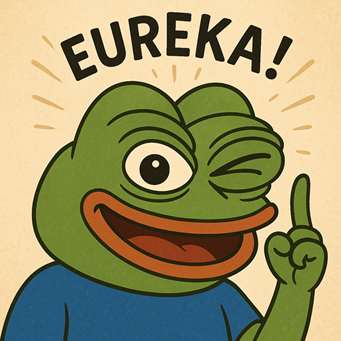